## Analysis of the workflow lifetime and disk utilization in CMS WM system

This notebook is meant to parse CMS Workload Management data for one year, ranging from 1st/July/2023 through 30/June/2024, and gather their total lifetime and disk requirements for input and output data.

In [1]:
import math
import os
import sys
import requests
import json
import statistics
import pandas as pd
from pprint import pprint
from tabulate import tabulate

In [2]:
myCert = "/Users/amaltar2/Devel/DockerWMCore/certs/servicecert.pem"
myKey = "/Users/amaltar2/Devel/DockerWMCore/certs/servicekey.pem"

## Step 1: Fetch workflow information from the primary data source for the last year

JSON format information is retrieved from the CMS Request Manager system through its REST API.

Note that this request can take a minute or more, given that we pull almost 2GB of raw data.

In [ ]:
%%time

headers = {"Content-type": "application/json", "Accept": "application/json"}
couchUrl = "https://cmsweb.cern.ch/couchdb/reqmgr_workload_cache/_design/ReqMgr/_view/bydate"
queryParams = {"startkey": "[2023,7,1]", "endkey": "[2024,6,30]", "include_docs": True}
raw_data = requests.get(couchUrl, params=queryParams, headers=headers, cert=(myCert, myKey), verify=False)
#print(data)
if raw_data.ok is True:
    raw_data = raw_data.json()['rows']
print(f"Total number of workflows: {len(raw_data)}")

### And dump it as JSON to avoid querying CouchDB all the time

In [ ]:
# data structure is in the format of, so let's fix this up
""" 
[
  {
    "doc": {
      "AcquisitionEra": "Run3Summer22wmLHEGS",
"""
raw_data = [doc['doc'] for doc in raw_data]
json_dump_file = "/Users/amaltar2/Pycharm/ProductionTools/raw_dump_2024.json"
with open(json_dump_file, "w") as jobj:
    json.dump(raw_data, jobj, indent=2, sort_keys=True)

In [ ]:
! ls -lah /Users/amaltar2/Pycharm/ProductionTools/raw_dump_2024.json

-rw-r--r--  1 amaltar2  staff   1.7G Jul 12 22:31 /Users/amaltar2/Pycharm/ProductionTools/raw_dump_2024.json


## Step 2: Create summary statistics for the raw data

We simply want to see the distribution of workflow types and archived statuses.

### Basic workflow raw distribution

In [57]:
column_names = ["Workflow Type", "Count"]
raw_table = {}
for doc in raw_data:
    raw_table.setdefault(doc["RequestType"], 0)
    raw_table[doc["RequestType"]] += 1
# create table
table_data = []
total = 0
for wf_type, wf_count in raw_table.items():
    table_data.append([wf_type, wf_count])
    total += wf_count
table_data.append(["TOTAL", total])
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

╒═════════════════╤═════════╕
│ Workflow Type   │   Count │
╞═════════════════╪═════════╡
│ TaskChain       │   65025 │
├─────────────────┼─────────┤
│ StepChain       │   45850 │
├─────────────────┼─────────┤
│ Resubmission    │   16916 │
├─────────────────┼─────────┤
│ ReReco          │    1198 │
├─────────────────┼─────────┤
│ DQMHarvest      │     186 │
├─────────────────┼─────────┤
│ TOTAL           │  129175 │
╘═════════════════╧═════════╛


In [58]:
column_names = ["Workflow Type", "Archived Status", "Count"]
raw_table = {}
for doc in raw_data:
    if "archived" not in doc["RequestStatus"]:
        continue  # workflow is not archived yet, skip it in this table
    raw_table.setdefault(doc["RequestType"], {})
    raw_table[doc["RequestType"]].setdefault(doc["RequestStatus"], 0)
    raw_table[doc["RequestType"]][doc["RequestStatus"]] += 1

table_data = []
total = 0
for wf_type, status_count in raw_table.items():
    for wf_status, wf_count in status_count.items():
        table_data.append([wf_type, wf_status, wf_count])
        total += wf_count
table_data.append(["TOTAL", total])
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

╒═════════════════╤═══════════════════╤═════════╕
│ Workflow Type   │ Archived Status   │   Count │
╞═════════════════╪═══════════════════╪═════════╡
│ TaskChain       │ rejected-archived │   38210 │
├─────────────────┼───────────────────┼─────────┤
│ TaskChain       │ normal-archived   │   13670 │
├─────────────────┼───────────────────┼─────────┤
│ TaskChain       │ aborted-archived  │   12507 │
├─────────────────┼───────────────────┼─────────┤
│ StepChain       │ normal-archived   │   22839 │
├─────────────────┼───────────────────┼─────────┤
│ StepChain       │ aborted-archived  │    2197 │
├─────────────────┼───────────────────┼─────────┤
│ StepChain       │ rejected-archived │     630 │
├─────────────────┼───────────────────┼─────────┤
│ Resubmission    │ normal-archived   │   12707 │
├─────────────────┼───────────────────┼─────────┤
│ Resubmission    │ aborted-archived  │     488 │
├─────────────────┼───────────────────┼─────────┤
│ Resubmission    │ rejected-archived │    2386 │


## Step 3: Raw data cleaning

In this process, we want to drop workflows that meet any of the following 3 conditions:

1. Resubmission workflows: given that input/output data locking is tracked through the original (parent) workflow, there is no need to consider these. 
2. Test and backfill workflows: this check is performed against the workflow name, attribute called `RequestName`. If it contains case-insensitive "backfill" or "test" in the workflow name, it is labeled as irrelevant for this analysis.
3. Workflows not processed in the system: workflows that have been either `aborted-archived` or `rejected-archived` AND that did not get into `running-open` or `running-closed` statuses. This needs to be done looking into the `RequestTransition` list of dictionaries.

**Acknowledgement**: Due to operational mistakes, eventual ACDCs are left behind in the system, in an active status, hence still keeping a lock on the input dataset to be kept on disk.

In [64]:
###
# raw_data contains all the data retrieved from CouchDB as a list of dictionaries
# clean_data is free of: a) test/backfill; b) resubmission; c) unprocessed data.
###
clean_data = []
resubmission, backfill, unprocessed = 0, 0, 0
for doc in raw_data:
    if doc["RequestType"] == "Resubmission":
        resubmission += 1
        continue
    if "test" in doc["RequestName"].lower() or "backfill" in doc["RequestName"].lower():
        # print(f"Backfill workflow droppped: {doc['RequestName']}")
        backfill += 1
        continue
    if doc["RequestStatus"] in ["aborted-archived", "rejected-archived"]:
        keep_wflow = False
        for st_trans in doc["RequestTransition"]:
            if "running" in st_trans["Status"]:
                keep_wflow = True
                break
        if not keep_wflow:
            unprocessed += 1
            continue
    # anything else is kept (or the processed+archived workflow above)
    clean_data.append(doc)
print(f"\nSUMMARY: dropped a total of {resubmission} Resubmission, {backfill} Backfill and {unprocessed} Unprocessed workflows")


SUMMARY: dropped a total of 16916 Resubmission, 128 Backfill and 49854 Unprocessed workflows


In [679]:
raw_data.clear()

In [65]:
# Recalculate workflow raw distributions
column_names = ["Workflow Type", "Count"]
raw_table = {}
for doc in clean_data:
    raw_table.setdefault(doc["RequestType"], 0)
    raw_table[doc["RequestType"]] += 1
# create table
table_data = []
total = 0
for wf_type, wf_count in raw_table.items():
    table_data.append([wf_type, wf_count])
    total += wf_count
table_data.append(["TOTAL", total])
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

╒═════════════════╤═════════╕
│ Workflow Type   │   Count │
╞═════════════════╪═════════╡
│ TaskChain       │   17228 │
├─────────────────┼─────────┤
│ StepChain       │   43827 │
├─────────────────┼─────────┤
│ ReReco          │    1047 │
├─────────────────┼─────────┤
│ DQMHarvest      │     175 │
├─────────────────┼─────────┤
│ TOTAL           │   62277 │
╘═════════════════╧═════════╛


### Persist clean data in a JSON file in the filesystem

In [66]:
json_dump_file = "/Users/amaltar2/Pycharm/ProductionTools/clean_dump_2024.json"
with open(json_dump_file, "w") as jobj:
    json.dump(clean_data, jobj, indent=2, sort_keys=True)

In [67]:
! ls -lah /Users/amaltar2/Pycharm/ProductionTools/clean_dump_2024.json

-rw-r--r--  1 amaltar2  staff   905M Jul 14 07:57 /Users/amaltar2/Pycharm/ProductionTools/clean_dump_2024.json


## Step 4: Integrate workflow data with data management (dataset sizes)

We have 2 different tools that can be used to define the dataset size:
* **DBS**: will contain the full size of the dataset, regardless whether files are valid or invalid.
* **Rucio**: will contain the full size of the dataset considering only existent replicas (so only actual data still living in the storage).

In this project, we will use **DBS**, as that reflects data that has been generated and stored, even if only temporarily.

**Acknowledgement**: some workflows do not require the full dataset to be on disk, as they might have run/block/lumi lists. This project assumes that the full dataset is required. Future projects might consider those delicate data details.

### Step 4a: Auxiliary functions to parse the workflow dictionary

#### Auxiliar function to retrieve number of events requested in a given workflow

In [338]:
# Find number of requested events
def get_event_number(wflow_desc):
    attr_name = "RequestNumEvents"
    if attr_name in wflow_desc and wflow_desc[attr_name]:
        return wflow_desc[attr_name]
    elif attr_name in wflow_desc.get("Task1", {}) and wflow_desc["Task1"][attr_name]:
        return wflow_desc["Task1"][attr_name]
    elif attr_name in wflow_desc.get("Step1", {}) and wflow_desc["Step1"][attr_name]:
        return wflow_desc["Step1"][attr_name]
    # fallback to TotalInputEvents
    if "TotalInputEvents" in wflow_desc:
        return wflow_desc["TotalInputEvents"]
    else:
        return None

#### Auxiliar function to find out input and pileup dataset(s) in a given workflow

In [339]:
# Auxiliar function to retrieve InputDataset or MCPileup from the workflow description
def get_input_data(wflow_desc, attr_name):
    if attr_name == "InputDataset":
        if "InputDataset" in wflow_desc and wflow_desc["InputDataset"]:
            return wflow_desc["InputDataset"]
        elif "InputDataset" in wflow_desc.get("Task1", {}) and wflow_desc["Task1"]["InputDataset"]:
            return wflow_desc["Task1"]["InputDataset"]
        elif "InputDataset" in wflow_desc.get("Step1", {}) and wflow_desc["Step1"]["InputDataset"]:
            return wflow_desc["Step1"]["InputDataset"]
        else:
            return None

    pu_set = set()
    if wflow_desc["RequestType"] in ("ReReco", "DQMHarvest"):
        return None  # there is no MCPileup
    if "TaskChain" in wflow_desc:
        t_name = "Task"
        counter = wflow_desc["TaskChain"]
    else:
        t_name = "Step"
        counter = wflow_desc["StepChain"]

    for i in range(1, counter + 1):
        this_t = f"{t_name}{i}"
        if "MCPileup" in wflow_desc[this_t] and wflow_desc[this_t]["MCPileup"]:
            pu_set.add(wflow_desc[this_t]["MCPileup"])
    
    if not pu_set:
        return None
    elif len(pu_set) > 1:
        print(f"Workflow {wflow_desc['RequestName']} has multiple pileups: {pu_set}")
    return list(pu_set)

#### Auxiliar function to calculate lifetime of a given workflow

`lifetime` corresponds to the difference of the workflow completion (timestamp of its `announced` status transition) and workflow assignment (timestamp of its `assigned` status transition).

For workflows that didn't follow their normal path, look for `aborted-completed` or `rejected` events; using that as end time.

Finally, for workflows that are yet in the system, we should probably set their `lifetime` as None (NA = not available). The analyst will then decide how to deal with those (perhaps using the median based on the workflow type).

In [340]:
def get_lifetime(doc):
    start_t, end_t = 0, 0
    for transit in doc["RequestTransition"]:
        if transit["Status"] == "assigned":
            start_t = transit["UpdateTime"]
        elif transit["Status"] == "announced":
            end_t = transit["UpdateTime"]
            break  # if we found "announced" status, then we are done iterating over this
        elif transit["Status"] == "aborted-completed":
            end_t = transit["UpdateTime"]
        elif transit["Status"] == "rejected":
            end_t = transit["UpdateTime"]
    
    if end_t and start_t:
        return end_t - start_t
    return None

#### Auxiliar function to convert from bytes to other units

In [767]:
# from https://stackoverflow.com/questions/5194057/better-way-to-convert-file-sizes-in-python
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def convert_to_PB(size_bytes):
    p = math.pow(1024, 5)
    s = round(size_bytes / p, 2)
    return s

### Step 4b: Concurrent HTTP function to contact the DBS data-service

In [342]:
import aiohttp
import asyncio
import ssl
from pprint import pprint
from itertools import islice


ssl_context = ssl.create_default_context()
ssl_context.load_cert_chain(myCert, keyfile=myKey)
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

http_headers = {"Content-type": "application/json", "Accept": "application/json"}

async def fetch_dbs_sizes(session, url):
    async with session.get(url, ssl=ssl_context) as resp:
        if resp.status >= 400:
            print(f"Failed to retrieve data from DBS for URL: {url}")
            return [{}]
        return await resp.json()

async def get_dbs_sizes(list_urls):
    tasks = []
    async with aiohttp.ClientSession(headers=http_headers) as session:
        for url in list_urls:
            tasks.append(fetch_dbs_sizes(session, url))
        resp = await asyncio.gather(*tasks)
        return resp

def get_subslice(iterable, step):
    iterable = iter(iterable)
    return iter(lambda: list(islice(iterable, step)), [])

### Step 4c: Discover all input dataset names and fetch their sizes from DBS

In [111]:
input_dsets = []
input_dset_sizes = {}
for doc in clean_data:
    dset_name = get_input_data(doc, "InputDataset")
    if dset_name:
        input_dsets.append(dset_name)
input_dsets = list(set(input_dsets))
print(f"Found a total of {len(input_dsets)} unique input datasets")

Found a total of 10504 unique input datasets


In [ ]:
dbs_url = "https://cmsweb-prod.cern.ch/dbs/prod/global/DBSReader"
list_urls = [f"{dbs_url}/filesummaries?dataset={dset}" for dset in input_dsets]

counter = 0
for sub_slice in get_subslice(list_urls, 25):
    print(f"Dataset count {counter * 25}...")
    resp = await get_dbs_sizes(sub_slice)
    # now parse responses
    for idx, this_url in enumerate(sub_slice):
        dset = this_url.split("=")[-1]
        input_dset_sizes.update({dset: resp[idx][0].get("file_size", None)})
    counter += 1

### Step 4d: Discover all pileup dataset names and fetch their sizes from DBS

In [136]:
pileup_dsets = []
pileup_dset_sizes = {}
for doc in clean_data:
    dset_name = get_input_data(doc, "MCPileup")
    if dset_name:
        pileup_dsets.extend(dset_name)
pileup_dsets = list(set(pileup_dsets))
print(f"Found a total of {len(pileup_dsets)} unique pileup datasets")

Workflow pdmvserv_task_SUS-RunIISummer20UL16GEN-00067__v1_T_240117_142217_3843 has multiple pileups: {'/Neutrino_E-10_gun/RunIISummer20ULPrePremix-UL16_106X_mcRun2_asymptotic_v13-v1/PREMIX', '/Neutrino_E-10_gun/RunIIFall17FSPrePremix-PUFSUL16CP5_106X_mcRun2_asymptotic_v16-v1/PREMIX'}
Workflow pdmvserv_task_SUS-RunIISummer20UL16GEN-00068__v1_T_240117_142149_4048 has multiple pileups: {'/Neutrino_E-10_gun/RunIISummer20ULPrePremix-UL16_106X_mcRun2_asymptotic_v13-v1/PREMIX', '/Neutrino_E-10_gun/RunIIFall17FSPrePremix-PUFSUL16CP5_106X_mcRun2_asymptotic_v16-v1/PREMIX'}
Workflow pdmvserv_task_SUS-RunIISummer20UL16GEN-00069__v1_T_240117_142212_4870 has multiple pileups: {'/Neutrino_E-10_gun/RunIISummer20ULPrePremix-UL16_106X_mcRun2_asymptotic_v13-v1/PREMIX', '/Neutrino_E-10_gun/RunIIFall17FSPrePremix-PUFSUL16CP5_106X_mcRun2_asymptotic_v16-v1/PREMIX'}
Workflow pdmvserv_task_SUS-RunIISummer20UL16GEN-00070__v1_T_240117_142301_589 has multiple pileups: {'/Neutrino_E-10_gun/RunIISummer20ULPrePremix

In [138]:
dbs_url = "https://cmsweb-prod.cern.ch/dbs/prod/global/DBSReader"
list_urls = [f"{dbs_url}/filesummaries?dataset={dset}" for dset in pileup_dsets]

counter = 0
for sub_slice in get_subslice(list_urls, 10):
    print(f"Dataset count {counter * 10}...")
    resp = await get_dbs_sizes(sub_slice)
    # now parse responses
    for idx, this_url in enumerate(sub_slice):
        dset = this_url.split("=")[-1]
        pileup_dset_sizes.update({dset: resp[idx][0].get("file_size", None)})
    counter += 1

Dataset count 0...
Dataset count 10...
Dataset count 20...
Dataset count 30...
Dataset count 40...
Dataset count 50...
Dataset count 60...
Dataset count 70...
Dataset count 80...
Dataset count 90...
Dataset count 100...
Dataset count 110...
Dataset count 120...


### Step 4e: Discover all output dataset names and fetch their sizes from DBS

In [139]:
output_dsets = []
output_dset_sizes = {}
for doc in clean_data:
    output_dsets.extend(doc["OutputDatasets"])
output_dsets = list(set(output_dsets))
print(f"Found a total of {len(output_dsets)} unique output datasets")

Found a total of 259444 unique output datasets


In [ ]:
dbs_url = "https://cmsweb-prod.cern.ch/dbs/prod/global/DBSReader"
list_urls = [f"{dbs_url}/filesummaries?dataset={dset}" for dset in output_dsets]

counter = 0
for sub_slice in get_subslice(list_urls, 25):
    print(f"Dataset count {counter * 25}...")
    resp = await get_dbs_sizes(sub_slice)
    # now parse responses
    for idx, this_url in enumerate(sub_slice):
        dset = this_url.split("=")[-1]
        output_dset_sizes.update({dset: resp[idx][0].get("file_size", None)})
    counter += 1

In [141]:
print("Total number of dataset sizes is:")
print(f"  * input dataset: {len(input_dset_sizes)}")
print(f"  * pileup dataset: {len(pileup_dset_sizes)}")
print(f"  * output dataset: {len(output_dset_sizes)}")

json_dump_file = "/Users/amaltar2/Pycharm/ProductionTools/input_dset_size.json"
with open(json_dump_file, "w") as jobj:
    json.dump(input_dset_sizes, jobj, indent=2, sort_keys=True)

json_dump_file = "/Users/amaltar2/Pycharm/ProductionTools/pileup_dset_size.json"
with open(json_dump_file, "w") as jobj:
    json.dump(pileup_dset_sizes, jobj, indent=2, sort_keys=True)

json_dump_file = "/Users/amaltar2/Pycharm/ProductionTools/output_dset_size.json"
with open(json_dump_file, "w") as jobj:
    json.dump(output_dset_sizes, jobj, indent=2, sort_keys=True)

Total number of dataset sizes is:
  * input dataset: 10504
  * pileup dataset: 123
  * output dataset: 259444


## Step 5: Define CSV structure and convert python dictionary data into CSV

In [343]:
# the csv column names are:
csv_columns = ["name", "events", "jobs", "type", "status", "lifetime",
               "has_input", "input_dset", "input_size",
               "pileup_dset_count", "pileup_type", "pileup_total_size",
               "output_dset_count", "output_total_size"]
# and timestamp related columns are:
ts_columns = ["new_ts", "assignment-approved_ts", "assigned_ts", "staging_ts",
              "staged_ts", "acquired_ts", "running-open_ts", "running-closed_ts",
              "completed_ts", "closed-out_ts", "announced_ts",
              "force-complete_ts", "aborted_ts", "aborted-completed_ts", "rejected_ts",
              "normal-archived_ts", "aborted-archived_ts", "rejected-archived_ts"]

## NOTE that some of the timestamps above will be missing not at random, as workflows 
## don't necessarily go through all of those statuses

In [344]:
dataset_csv = []
# first, add feature names / columns
dataset_csv.append(csv_columns)
dataset_csv[0].extend(ts_columns)
print(dataset_csv)

# this is going to be one row per workflow. NOTE that order of features matter here!
for doc in clean_data:
    wflow_csv = []
    ### DEAL with csv_columns
    wflow_csv.append(doc["RequestName"])
    evts = get_event_number(doc)
    wflow_csv.append(get_event_number(doc))
    wflow_csv.append(doc['TotalEstimatedJobs'] if "TotalEstimatedJobs" in doc else None)
    wflow_csv.append(doc["RequestType"])
    wflow_csv.append(doc["RequestStatus"])
    wflow_csv.append(get_lifetime(doc))
    # has_input, input_dset, input_size
    input_dset = get_input_data(doc, "InputDataset")
    wflow_csv.append(1 if input_dset else 0)
    wflow_csv.append(input_dset)
    wflow_csv.append(input_dset_sizes[input_dset] if input_dset else 0)
    # pileup_dset_count, pileup_type, pileup_total_size
    pu_dset = get_input_data(doc, "MCPileup")
    if pu_dset:
        wflow_csv.append(len(pu_dset))
        pu_type = "classic"
        for pu in pu_dset:
            if pu.endswith("/PREMIX"):
                pu_type = "premix"
        wflow_csv.append(pu_type)
        wflow_csv.append(sum([pileup_dset_sizes[dset] for dset in pu_dset]))
    else:
        wflow_csv.append(0)
        wflow_csv.append(None)
        wflow_csv.append(0)
    # output_dset_count, output_total_size
    out_dset = doc["OutputDatasets"]
    if out_dset:
        wflow_csv.append(len(out_dset))
        wflow_csv.append(sum([output_dset_sizes[dset] for dset in out_dset]))
    else:
        wflow_csv.append(0)
        wflow_csv.append(0)
    
    ### DEAL with ts_columns
    for entry in ts_columns:
        status = entry.replace("_ts", "")
        status_updated = False
        for transition in doc["RequestTransition"]:
            if status == transition["Status"]:
                wflow_csv.append(transition["UpdateTime"])
                status_updated = True
                break
        if not status_updated:
            wflow_csv.append(None)
    
    ### FINALLY, add this workflow row into our dataset
    dataset_csv.append(wflow_csv)

[['name', 'events', 'jobs', 'type', 'status', 'lifetime', 'has_input', 'input_dset', 'input_size', 'pileup_dset_count', 'pileup_type', 'pileup_total_size', 'output_dset_count', 'output_total_size', 'new_ts', 'assignment-approved_ts', 'assigned_ts', 'staging_ts', 'staged_ts', 'acquired_ts', 'running-open_ts', 'running-closed_ts', 'completed_ts', 'closed-out_ts', 'announced_ts', 'force-complete_ts', 'aborted_ts', 'aborted-completed_ts', 'rejected_ts', 'normal-archived_ts', 'aborted-archived_ts', 'rejected-archived_ts']]
Workflow pdmvserv_task_SUS-RunIISummer20UL16GEN-00067__v1_T_240117_142217_3843 has multiple pileups: {'/Neutrino_E-10_gun/RunIISummer20ULPrePremix-UL16_106X_mcRun2_asymptotic_v13-v1/PREMIX', '/Neutrino_E-10_gun/RunIIFall17FSPrePremix-PUFSUL16CP5_106X_mcRun2_asymptotic_v16-v1/PREMIX'}
Workflow pdmvserv_task_SUS-RunIISummer20UL16GEN-00068__v1_T_240117_142149_4048 has multiple pileups: {'/Neutrino_E-10_gun/RunIISummer20ULPrePremix-UL16_106X_mcRun2_asymptotic_v13-v1/PREMIX', 

In [345]:
import csv
csv_dump_file = "/Users/amaltar2/Pycharm/ProductionTools/formatted_data.csv"     
print(f"Going to save a total of {len(dataset_csv)} rows in file: {csv_dump_file}")
with open(csv_dump_file, 'w') as f:     
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(dataset_csv)

Going to save a total of 62278 rows in file: /Users/amaltar2/Pycharm/ProductionTools/formatted_data.csv


## Step 6: Read CSV into DataFrame and deal with missing data

In [608]:
df = pd.read_csv(csv_dump_file)
df.describe(percentiles=[0.05, 0.25, 0.75, 0.95]) 

,events,jobs,lifetime,has_input,input_size,pileup_dset_count,pileup_total_size,output_dset_count,output_total_size,new_ts,assignment-approved_ts,assigned_ts,staging_ts,staged_ts,acquired_ts,running-open_ts,running-closed_ts,completed_ts,closed-out_ts,announced_ts,force-complete_ts,aborted_ts,aborted-completed_ts,rejected_ts,normal-archived_ts,aborted-archived_ts,rejected-archived_ts
count,6.225600e+04,6.213900e+04,5.443800e+04,62277.000000,6.227700e+04,62277.000000,6.227700e+04,62277.000000,6.227700e+04,6.227700e+04,6.221500e+04,6.215600e+04,6.215400e+04,6.215300e+04,6.215000e+04,5.591300e+04,5.545000e+04,5.228300e+04,5.101000e+04,5.076900e+04,3.720000e+02,2.571000e+03,2.570000e+03,1.531000e+03,3.731600e+04,2.553000e+03,1.401000e+03
mean,4.489433e+06,2.118650e+03,2.714507e+06,0.230406,2.272781e+12,0.738635,4.416147e+14,4.173371,1.185857e+12,1.704552e+09,1.704557e+09,1.704786e+09,1.704786e+09,1.704806e+09,1.704808e+09,1.705826e+09,1.705931e+09,1.706196e+09,1.706411e+09,1.706439e+09,1.707481e+09,1.702572e+09,1.702574e+09,1.703354e+09,1.702961e+09,1.702649e+09,1.702011e+09
std,5.049683e+07,2.369890e+04,3.336203e+06,0.421096,1.672860e+13,0.440112,3.200856e+14,3.905154,1.184035e+13,8.301992e+06,8.303328e+06,8.587641e+06,8.587410e+06,8.569868e+06,8.569834e+06,9.433842e+06,9.373894e+06,9.411786e+06,9.367302e+06,9.359389e+06,6.228929e+06,4.580312e+06,4.580911e+06,8.210985e+06,7.321787e+06,4.378949e+06,6.753272e+06
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.688255e+09,1.688356e+09,1.688359e+09,1.688359e+09,1.688362e+09,1.688363e+09,1.688363e+09,1.688363e+09,1.688390e+09,1.688390e+09,1.688394e+09,1.692275e+09,1.688701e+09,1.688702e+09,1.688701e+09,1.688595e+09,1.688887e+09,1.688887e+09
5%,9.000000e+03,6.000000e+00,7.351255e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,2.000000,0.000000e+00,1.692270e+09,1.692270e+09,1.692273e+09,1.692273e+09,1.692274e+09,1.692275e+09,1.692271e+09,1.692283e+09,1.692347e+09,1.692372e+09,1.692492e+09,1.698056e+09,1.694763e+09,1.694764e+09,1.693596e+09,1.692277e+09,1.694960e+09,1.692956e+09
25%,2.500000e+04,2.900000e+01,3.776862e+05,0.000000,0.000000e+00,0.000000,0.000000e+00,3.000000,1.073697e+10,1.697326e+09,1.697245e+09,1.697265e+09,1.697229e+09,1.697635e+09,1.697642e+09,1.696666e+09,1.697211e+09,1.697256e+09,1.697451e+09,1.697444e+09,1.703595e+09,1.701349e+09,1.701350e+09,1.698248e+09,1.697545e+09,1.701534e+09,1.697911e+09
50%,1.000000e+05,9.000000e+01,1.215317e+06,0.000000,0.000000e+00,1.000000,5.994551e+14,3.000000,4.626750e+10,1.703095e+09,1.703095e+09,1.703096e+09,1.703096e+09,1.703099e+09,1.703100e+09,1.704816e+09,1.704863e+09,1.705505e+09,1.705873e+09,1.705875e+09,1.709223e+09,1.701369e+09,1.701371e+09,1.699641e+09,1.702332e+09,1.701565e+09,1.699836e+09
75%,3.493000e+05,2.270000e+02,3.700735e+06,0.000000,0.000000e+00,1.000000,7.189785e+14,3.000000,1.695072e+11,1.711277e+09,1.711278e+09,1.711279e+09,1.711279e+09,1.711281e+09,1.711282e+09,1.714675e+09,1.714676e+09,1.714755e+09,1.714780e+09,1.714769e+09,1.711825e+09,1.701448e+09,1.701452e+09,1.709116e+09,1.708281e+09,1.701624e+09,1.706327e+09
95%,1.000000e+07,4.001100e+03,9.295198e+06,1.000000,2.123288e+12,1.000000,8.188694e+14,16.000000,2.559596e+12,1.717689e+09,1.717689e+09,1.719279e+09,1.719279e+09,1.719280e+09,1.719282e+09,1.719361e+09,1.719511e+09,1.719616e+09,1.719698e+09,1.719732e+09,1.717463e+09,1.711194e+09,1.711195e+09,1.719913e+09,1.715848e+09,1.711329e+09,1.715789e+09
max,5.677138e+09,2.337314e+06,2.434098e+07,1.000000,5.562782e+14,2.000000,8.188694e+14,19.000000,8.188694e+14,1.719703e+09,1.719913e+09,1.720794e+09,1.720794e+09,1.720795e+09,1.720796e+09,1.720836e+09,1.720836e+09,1.720830e+09,1.720836e+09,1.720833e+09,1.720683e+09,1.720430e+09,1.720430e+09,1.720767e+09,1.719240e+09,1.718996e+09,1.719210e+09


In [609]:
# Set display options to prevent truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
df.head()

,name,events,jobs,type,status,lifetime,has_input,input_dset,input_size,pileup_dset_count,pileup_type,pileup_total_size,output_dset_count,output_total_size,new_ts,assignment-approved_ts,assigned_ts,staging_ts,staged_ts,acquired_ts,running-open_ts,running-closed_ts,completed_ts,closed-out_ts,announced_ts,force-complete_ts,aborted_ts,aborted-completed_ts,rejected_ts,normal-archived_ts,aborted-archived_ts,rejected-archived_ts
0,pdmvserv_task_EXO-RunIISummer16NanoAODv7-11118__v1_T_230701_235132_9824,591200.0,9.0,TaskChain,normal-archived,23542.0,1,/HeavyNeutrino_lljj_M-21_V-0p00223606_mu_massive_LO_13TeV_TuneCUETP8M1_madgraph-pythia8/RunIISummer16MiniAODv3-PUMoriond17_94X_mcRun2_asymptotic_v3-v1/MINIAODSIM,18907744976,0,NaN,0,1,583188511,1688255492,1.688377e+09,1.688379e+09,1.688379e+09,1.688380e+09,1.688380e+09,1.688382e+09,1.688382e+09,1.688401e+09,1.688401e+09,1.688403e+09,NaN,NaN,NaN,NaN,1.688595e+09,NaN,NaN
1,pdmvserv_task_EXO-RunIISummer16NanoAODv7-11119__v1_T_230701_235133_647,576000.0,8.0,TaskChain,normal-archived,23130.0,1,/HeavyNeutrino_lljj_M-22_V-0p002236_mu_massive_LO_13TeV_TuneCUETP8M1_madgraph-pythia8/RunIISummer16MiniAODv3-PUMoriond17_94X_mcRun2_asymptotic_v3-v1/MINIAODSIM,18391842001,0,NaN,0,1,568671804,1688255493,1.688377e+09,1.688379e+09,1.688379e+09,1.688380e+09,1.688380e+09,1.688382e+09,1.688382e+09,1.688398e+09,1.688401e+09,1.688402e+09,NaN,NaN,NaN,NaN,1.688595e+09,NaN,NaN
2,pdmvserv_task_EXO-RunIISummer16NanoAODv7-11120__v1_T_230703_001027_2389,573800.0,8.0,TaskChain,normal-archived,31130.0,1,/HeavyNeutrino_lljj_M-21_V-0p000316_mu_massive_LO_13TeV_TuneCUETP8M1_madgraph-pythia8/RunIISummer16MiniAODv3-PUMoriond17_94X_mcRun2_asymptotic_v3-v1/MINIAODSIM,19195461897,0,NaN,0,1,572045167,1688343027,1.688377e+09,1.688379e+09,1.688379e+09,1.688381e+09,1.688381e+09,1.688383e+09,1.688384e+09,1.688405e+09,1.688408e+09,1.688410e+09,NaN,NaN,NaN,NaN,1.688595e+09,NaN,NaN
3,pdmvserv_RVCMSSW_13_2_0_pre2CloseByPGun_CE_E_Front_120um__2026D98PU200_230703_035212_5689,9000.0,90.0,TaskChain,normal-archived,36396.0,1,/RelValCloseByPGun_CE_E_Front_120um/CMSSW_13_2_0_pre2-131X_mcRun4_realistic_v6_2026D98noPU-v1/GEN-SIM,227253429,1,classic,33172007309,4,1833519030634,1688356332,1.688356e+09,1.688359e+09,1.688359e+09,1.688362e+09,1.688363e+09,1.688363e+09,1.688363e+09,1.688393e+09,1.688394e+09,1.688396e+09,NaN,NaN,NaN,NaN,1.688595e+09,NaN,NaN
4,pdmvserv_RVCMSSW_13_2_0_pre2SinglePiFlatPt0p7To10__2026D98PU200_230703_035212_5726,9000.0,90.0,TaskChain,normal-archived,34550.0,1,/RelValSinglePiFlatPt0p7To10/CMSSW_13_2_0_pre2-131X_mcRun4_realistic_v6_2026D98noPU-v1/GEN-SIM,202591012,1,classic,33172007309,4,1833392474932,1688356332,1.688356e+09,1.688359e+09,1.688359e+09,1.688362e+09,1.688363e+09,1.688363e+09,1.688363e+09,1.688390e+09,1.688390e+09,1.688394e+09,NaN,NaN,NaN,NaN,1.688595e+09,NaN,NaN


### Step 6a: Data imputation for lifetime feature (based on the actual workflow type)

In [610]:
### Drop workflows with 0 lifetime
print(f"Workflows in the dataset: {len(df)}")
df = df.drop(df[df['lifetime'] == 0].index)
print(f"Workflows in the dataset with non-zero lifetime: {len(df)}")

Workflows in the dataset: 62277
Workflows in the dataset with non-zero lifetime: 62276


In [611]:
### Calculate mean lifetime for TaskChain, StepChain and ReReco
rereco_df = df.loc[df['type'] == "ReReco"]
rereco_mean = int(rereco_df['lifetime'].mean())
rereco_median = rereco_df['lifetime'].median()

taskchain_df = df.loc[df['type'] == "TaskChain"]
taskchain_mean = int(taskchain_df['lifetime'].mean())
taskchain_median = taskchain_df['lifetime'].median()

stepchain_df = df.loc[df['type'] == "StepChain"]
stepchain_mean = int(stepchain_df['lifetime'].mean())
stepchain_median = stepchain_df['lifetime'].median()

print(f"Mean for ReReco:   {rereco_mean},  for TaskChain: {taskchain_mean},  for StepChain: {stepchain_mean}")
print(f"Median for ReReco: {rereco_median}, for TaskChain: {taskchain_median}, for StepChain: {stepchain_median}")

Mean for ReReco:   1694184,  for TaskChain: 985533,  for StepChain: 3565676
Median for ReReco: 989970.5, for TaskChain: 297527.0, for StepChain: 2440432.5


In [612]:
### FIXME TODO: use median or mean?? For now, setting it to the median value
# If workflow didn't have a "running-closed" status, set its lifetime to the mean of its workflow type
df.loc[(df['type'] == "ReReco") & (df['running-closed_ts'].isna()), 'lifetime'] = rereco_median
df.loc[(df['type'] == "TaskChain") & (df['running-closed_ts'].isna()), 'lifetime'] = taskchain_median
df.loc[(df['type'] == "StepChain") & (df['running-closed_ts'].isna()), 'lifetime'] = stepchain_median

# Calculate mean between "acquired" and "assigned" status, set workflows missing acquired value to this value
mean_acquired = (df['acquired_ts'] - df['assigned_ts']).mean()
df.loc[df['acquired_ts'].isna(), 'lifetime'] = mean_acquired
print(f"Mean lifetime for workflows missing acquired timestamp: {mean_acquired}")

# If workflow didn't have a "staging" status, set its lifetime to 0
df.loc[df['staging_ts'].isna(), 'lifetime'] = 0
df.loc[df['assigned_ts'].isna(), 'lifetime'] = 0
df.loc[df['assignment-approved_ts'].isna(), 'lifetime'] = 0

Mean lifetime for workflows missing acquired timestamp: 21692.60237493765


In [613]:
print(f"Now with {len(df[df['lifetime'] == 0])} workflows with 0 lifetime. Dropping them!")
df = df.drop(df[df['lifetime'] == 0].index)
print(f"Workflows in the dataset with non-zero lifetime: {len(df)}")

# describe again the new data
df.describe(percentiles=[0.05, 0.25, 0.75, 0.95])

Now with 123 workflows with 0 lifetime. Dropping them!
Workflows in the dataset with non-zero lifetime: 62153


,events,jobs,lifetime,has_input,input_size,pileup_dset_count,pileup_total_size,output_dset_count,output_total_size,new_ts,assignment-approved_ts,assigned_ts,staging_ts,staged_ts,acquired_ts,running-open_ts,running-closed_ts,completed_ts,closed-out_ts,announced_ts,force-complete_ts,aborted_ts,aborted-completed_ts,rejected_ts,normal-archived_ts,aborted-archived_ts,rejected-archived_ts
count,6.214900e+04,6.213800e+04,6.079900e+04,62153.000000,6.215300e+04,62153.000000,6.215300e+04,62153.000000,6.215300e+04,6.215300e+04,6.215300e+04,6.215300e+04,6.215300e+04,6.215200e+04,6.214900e+04,5.591300e+04,5.545000e+04,5.228300e+04,5.101000e+04,5.076900e+04,3.720000e+02,2.570000e+03,2.569000e+03,1.498000e+03,3.731600e+04,2.553000e+03,1.401000e+03
mean,4.469754e+06,2.118684e+03,2.675700e+06,0.230592,2.275491e+12,0.738854,4.420279e+14,4.166396,1.187318e+12,1.704541e+09,1.704545e+09,1.704785e+09,1.704786e+09,1.704806e+09,1.704808e+09,1.705826e+09,1.705931e+09,1.706196e+09,1.706411e+09,1.706439e+09,1.707481e+09,1.702566e+09,1.702567e+09,1.703004e+09,1.702961e+09,1.702649e+09,1.702011e+09
std,5.052118e+07,2.369908e+04,3.154930e+06,0.421215,1.674246e+13,0.439775,3.199616e+14,3.895825,1.184998e+13,8.298557e+06,8.297360e+06,8.587431e+06,8.587403e+06,8.569861e+06,8.569827e+06,9.433842e+06,9.373894e+06,9.411786e+06,9.367302e+06,9.359389e+06,6.228929e+06,4.568870e+06,4.569468e+06,7.948808e+06,7.321787e+06,4.378949e+06,6.753272e+06
min,0.000000e+00,1.000000e+00,3.477000e+03,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.688255e+09,1.688356e+09,1.688359e+09,1.688359e+09,1.688362e+09,1.688363e+09,1.688363e+09,1.688363e+09,1.688390e+09,1.688390e+09,1.688394e+09,1.692275e+09,1.688701e+09,1.688702e+09,1.688701e+09,1.688595e+09,1.688887e+09,1.688887e+09
5%,9.000000e+03,6.000000e+00,7.859970e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,2.000000,0.000000e+00,1.692270e+09,1.692270e+09,1.692273e+09,1.692273e+09,1.692274e+09,1.692275e+09,1.692271e+09,1.692283e+09,1.692347e+09,1.692372e+09,1.692492e+09,1.698056e+09,1.694763e+09,1.694764e+09,1.693588e+09,1.692277e+09,1.694960e+09,1.692956e+09
25%,2.500000e+04,2.900000e+01,4.515485e+05,0.000000,0.000000e+00,0.000000,0.000000e+00,3.000000,1.088368e+10,1.697142e+09,1.697142e+09,1.697210e+09,1.697210e+09,1.697635e+09,1.697642e+09,1.696666e+09,1.697211e+09,1.697256e+09,1.697451e+09,1.697444e+09,1.703595e+09,1.701349e+09,1.701350e+09,1.698248e+09,1.697545e+09,1.701534e+09,1.697911e+09
50%,1.000000e+05,9.000000e+01,1.634815e+06,0.000000,0.000000e+00,1.000000,5.994551e+14,3.000000,4.638282e+10,1.703093e+09,1.703093e+09,1.703096e+09,1.703096e+09,1.703099e+09,1.703100e+09,1.704816e+09,1.704863e+09,1.705505e+09,1.705873e+09,1.705875e+09,1.709223e+09,1.701368e+09,1.701369e+09,1.699641e+09,1.702332e+09,1.701565e+09,1.699836e+09
75%,3.493000e+05,2.270000e+02,3.372642e+06,0.000000,0.000000e+00,1.000000,7.189785e+14,3.000000,1.702880e+11,1.711277e+09,1.711277e+09,1.711279e+09,1.711279e+09,1.711281e+09,1.711282e+09,1.714675e+09,1.714676e+09,1.714755e+09,1.714780e+09,1.714769e+09,1.711825e+09,1.701448e+09,1.701452e+09,1.707731e+09,1.708281e+09,1.701624e+09,1.706327e+09
95%,1.000000e+07,4.001150e+03,9.196025e+06,1.000000,2.126851e+12,1.000000,8.188694e+14,16.000000,2.567447e+12,1.717689e+09,1.717689e+09,1.719279e+09,1.719279e+09,1.719280e+09,1.719282e+09,1.719361e+09,1.719511e+09,1.719616e+09,1.719698e+09,1.719732e+09,1.717463e+09,1.711183e+09,1.711184e+09,1.719913e+09,1.715848e+09,1.711329e+09,1.715789e+09
max,5.677138e+09,2.337314e+06,2.434098e+07,1.000000,5.562782e+14,2.000000,8.188694e+14,19.000000,8.188694e+14,1.719703e+09,1.719913e+09,1.720794e+09,1.720794e+09,1.720795e+09,1.720796e+09,1.720836e+09,1.720836e+09,1.720830e+09,1.720836e+09,1.720833e+09,1.720683e+09,1.720430e+09,1.720430e+09,1.720767e+09,1.719240e+09,1.718996e+09,1.719210e+09


In [615]:
print(f"Total number of workflows with 0 input size: {len(df[df['input_size'] == 0])}")
print(f"Total number of workflows with 0 pileup size: {len(df[df['pileup_total_size'] == 0])}")
print(f"Total number of workflows with 0 output size: {len(df[df['output_total_size'] == 0])}")
df[df["output_total_size"] < 1]

Total number of workflows with 0 input size: 47821
Total number of workflows with 0 pileup size: 16245
Total number of workflows with 0 output size: 8519


,name,events,jobs,type,status,lifetime,has_input,input_dset,input_size,pileup_dset_count,pileup_type,pileup_total_size,output_dset_count,output_total_size,new_ts,assignment-approved_ts,assigned_ts,staging_ts,staged_ts,acquired_ts,running-open_ts,running-closed_ts,completed_ts,closed-out_ts,announced_ts,force-complete_ts,aborted_ts,aborted-completed_ts,rejected_ts,normal-archived_ts,aborted-archived_ts,rejected-archived_ts
73,pdmvserv_task_HIN-HINPbPbAutumn22wmLHEGS-00002__v1_T_230705_202342_2588,10000.0,1.0,TaskChain,rejected-archived,109468.0,0,NaN,0,0,NaN,0,2,0,1688588622,1.688589e+09,1.688591e+09,1.688592e+09,1.688594e+09,1.688594e+09,1.688595e+09,1.688595e+09,1.688599e+09,NaN,NaN,NaN,NaN,NaN,1.688701e+09,NaN,NaN,1.688887e+09
219,pdmvserv_RVCMSSW_13_2_0_pre2TTbar_14TeV__2026D98PU200_RECOonly_230714_094113_9107,9000.0,90.0,TaskChain,normal-archived,9146.0,1,/RelValTTbar_14TeV/CMSSW_13_1_0_pre4-PU_131X_mcRun4_realistic_v3_2026D98PU200-v1/GEN-SIM-DIGI-RAW,729270396106,1,classic,33172007309,3,0,1689327673,1.689328e+09,1.689329e+09,1.689332e+09,1.689332e+09,1.689333e+09,1.689333e+09,1.689333e+09,1.689336e+09,1.689337e+09,1.689339e+09,NaN,NaN,NaN,NaN,1.689541e+09,NaN,NaN
220,pdmvserv_RVCMSSW_13_2_0_pre2TTbar_14TeV__RECOonly_230714_093624_8597,9000.0,90.0,TaskChain,normal-archived,9054.0,1,/RelValTTbar_14TeV/CMSSW_13_1_0_pre4-PU_131X_mcRun3_2022_realistic_v3-v1/GEN-SIM-DIGI-RAW,329195021774,1,classic,17489602019,4,0,1689327384,1.689327e+09,1.689329e+09,1.689332e+09,1.689332e+09,1.689333e+09,1.689333e+09,1.689333e+09,1.689337e+09,1.689337e+09,1.689339e+09,NaN,NaN,NaN,NaN,1.689540e+09,NaN,NaN
221,pdmvserv_RVCMSSW_13_2_0_pre2ZMM_14__RECOonly_230714_093624_8687,15359.0,180.0,TaskChain,normal-archived,9567.0,1,/RelValZMM_14/CMSSW_13_1_0_pre4-PU_131X_mcRun3_2022_realistic_v3-v1/GEN-SIM-DIGI-RAW,553237833718,1,classic,17489602019,4,0,1689327384,1.689327e+09,1.689329e+09,1.689332e+09,1.689332e+09,1.689333e+09,1.689333e+09,1.689333e+09,1.689337e+09,1.689337e+09,1.689339e+09,NaN,NaN,NaN,NaN,1.689541e+09,NaN,NaN
401,pdmvserv_Run2023D_SpecialZeroBias0_17Jul2023_230717_104415_2537,16282700.0,566.0,ReReco,rejected-archived,895440.0,1,/SpecialZeroBias0/Run2023D-v1/RAW,1908817887056,0,NaN,0,3,0,1689590655,1.689591e+09,1.689592e+09,1.689592e+09,1.689593e+09,1.689594e+09,1.689595e+09,1.689596e+09,1.689603e+09,NaN,NaN,NaN,NaN,NaN,1.690488e+09,NaN,NaN,1.690678e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62101,pdmvserv_RVCMSSW_14_1_0_pre4RunEGamma2022C__STD_2022_Data_RelVal_2022C_240627_132616_8525,309494.0,4.0,TaskChain,announced,638475.0,1,/EGamma/Run2022C-v1/RAW,204817312049417,0,NaN,0,5,0,1719494776,1.719495e+09,1.719498e+09,1.719498e+09,1.719500e+09,1.719501e+09,1.719502e+09,1.719502e+09,1.719596e+09,1.719599e+09,1.720136e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62127,wangz_task_TSG-Run3Winter24Digi-00252__v1_T_240628_024502_1448,4923600.0,6389.0,StepChain,aborted-completed,2440432.5,1,/SinglePion_Pt-0To200_gun/Run3Winter24GS-133X_mcRun3_2024_realistic_v7-v2/GEN-SIM,160074780723,1,classic,19536466647594,5,0,1719542702,1.719543e+09,1.719543e+09,1.719543e+09,1.719544e+09,1.719544e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.719597e+09,1.719598e+09,NaN,NaN,NaN,NaN
62128,wangz_task_TSG-Run3Winter24Digi-00253__v1_T_240628_024644_8022,4499263.0,5838.0,StepChain,aborted-completed,2440432.5,1,/SinglePion_Pt-200To500_gun/Run3Winter24GS-133X_mcRun3_2024_realistic_v7-v2/GEN-SIM,300982485343,1,classic,19536466647594,5,0,1719542804,1.719543e+09,1.719543e+09,1.719543e+09,1.719544e+09,1.719544e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.719598e+09,1.719600e+09,NaN,NaN,NaN,NaN
62129,wangz_task_TSG-Run3Winter24Digi-00260__v1_T_240628_024543_6810,4923600.0,6389.0,StepChain,aborted-completed,2440432.5,1,/SinglePion_Pt-0To200_gun/Run3Winter24GS-133X_mcRun3_2024_realistic_v7-v2/GEN-SIM,160074780723,1,classic,19536466647594,5,0,1719542743,1.719543e+09,1.719543e+09,1.719543e+09,1.719544e+09,1.719545e+09,NaN,NaN,NaN,

In [616]:
### Take a peek at the worst offenders for lifetime and events 
max_lifetime_index = df['lifetime'].idxmax()
print(df.loc[max_lifetime_index])

max_evts_index = df['events'].idxmax()
print(df.loc[max_evts_index])

#df[df["name"] == "wangz_task_TSG-Run3Winter24GS-00266__v1_T_240628_025015_6323"]

name                      cmsunified_task_HIG-RunIISummer20UL16wmLHEGEN-14343__v1_T_231005_060455_5206
events                                                                                        250000.0
jobs                                                                                             269.0
type                                                                                         StepChain
status                                                                                       announced
lifetime                                                                                    24340984.0
has_input                                                                                            0
input_dset                                                                                         NaN
input_size                                                                                           0
pileup_dset_count                                                        

### Step 6b: create plots for continuous values with non-transformed data (standardized/normalized)

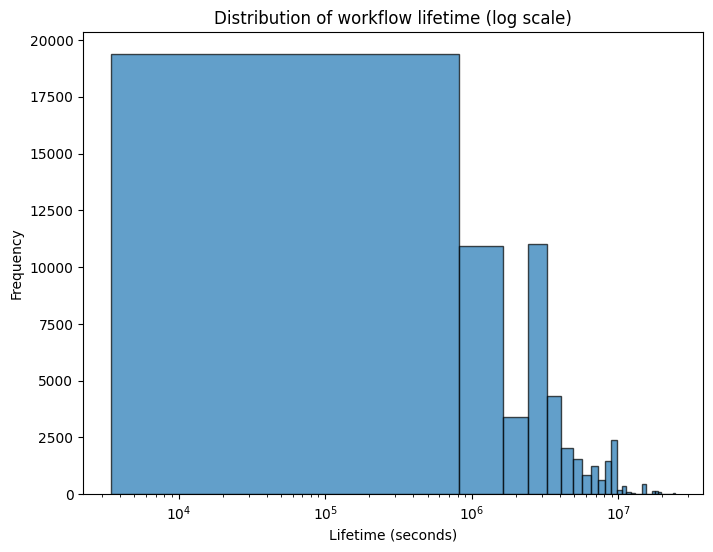

In [617]:
import matplotlib.pyplot as plt

# Plot distribution of the lifetime attribute
plt.figure(figsize=(8, 6))
plt.hist(df['lifetime'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of workflow lifetime (log scale)')
plt.xlabel('Lifetime (seconds)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()

#### Distribution of pileup and output dataset counts

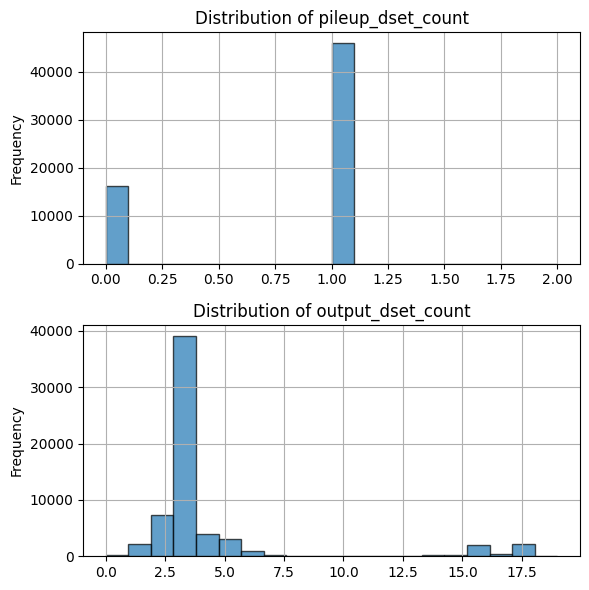

In [618]:
# continuous features to plot a histogram for
bad_cont_features = ["pileup_dset_count", "output_dset_count"]
fig, ax = plt.subplots(nrows=len(bad_cont_features), figsize=(6,3*len(bad_cont_features)))
for i, col in enumerate(bad_cont_features):
    this_title = f"Distribution of {col}"
    df[col].plot(kind='hist', ax=ax[i], title=this_title, bins=20, grid=True, edgecolor='k', alpha=0.7)
    
plt.tight_layout()

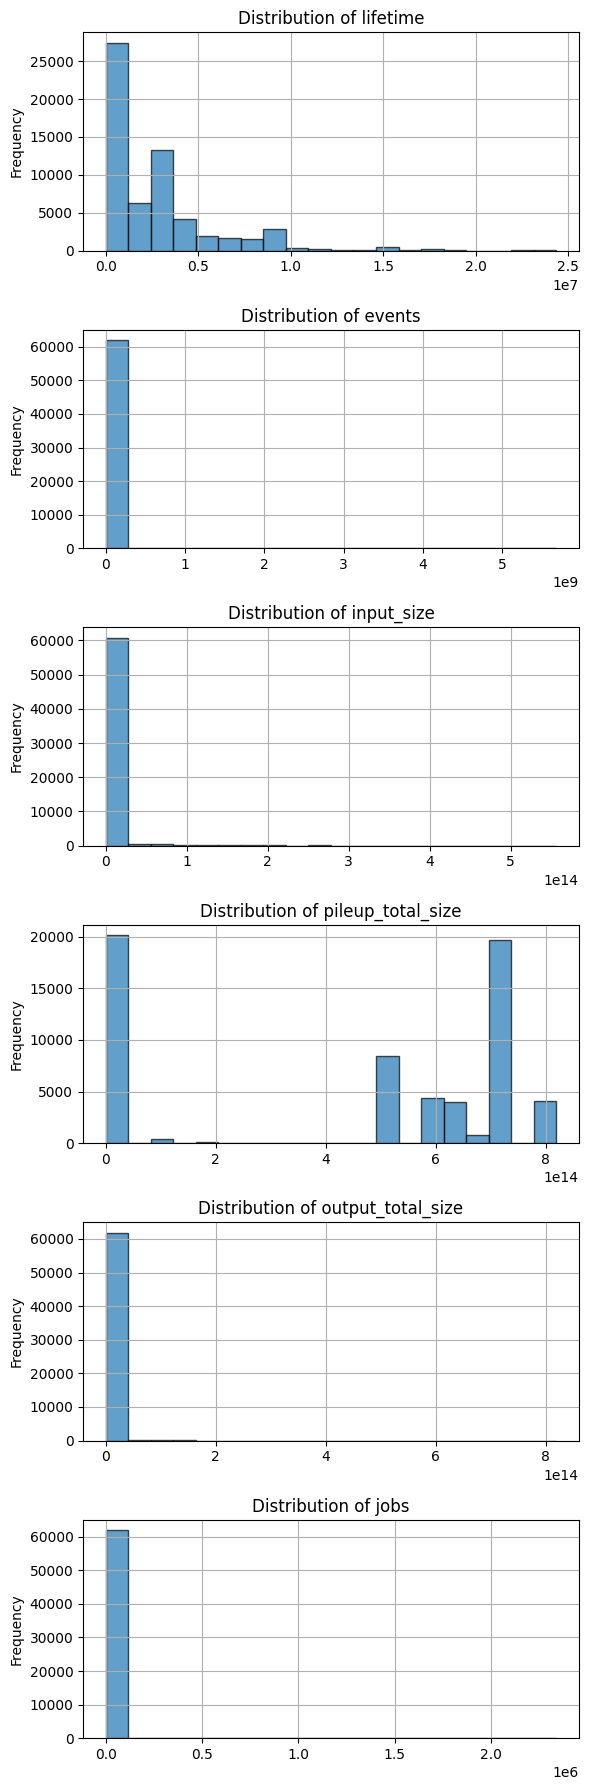

In [620]:
good_cont_features = ["lifetime", "events", "input_size", "pileup_total_size",  "output_total_size", "jobs"]

fig, ax = plt.subplots(nrows=len(good_cont_features), figsize=(6,3*len(good_cont_features)))
for i, col in enumerate(good_cont_features):
    this_title = f"Distribution of {col}"
    df[col].plot(kind='hist', ax=ax[i], title=this_title, bins=20, grid=True, edgecolor='k', alpha=0.7)
    
plt.tight_layout()

#### Make boxplots for continuous features

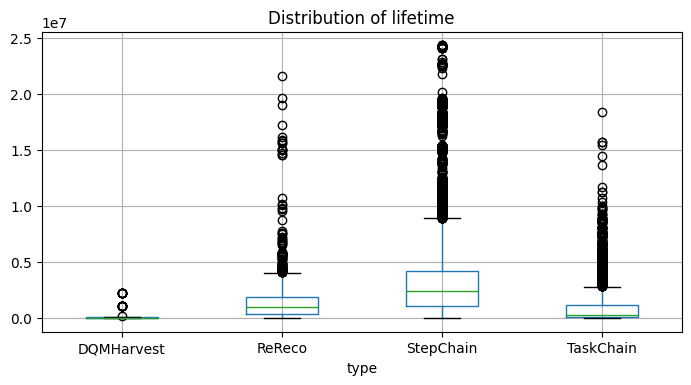

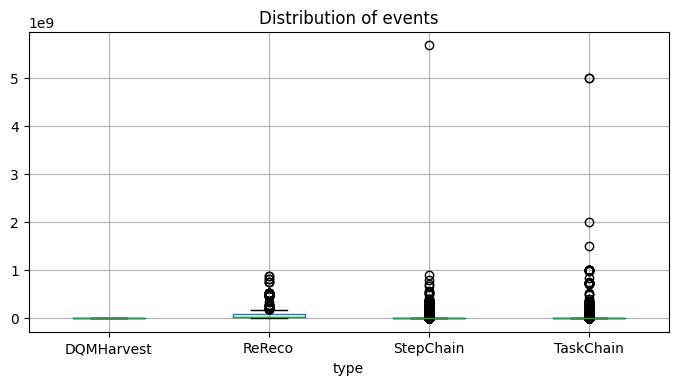

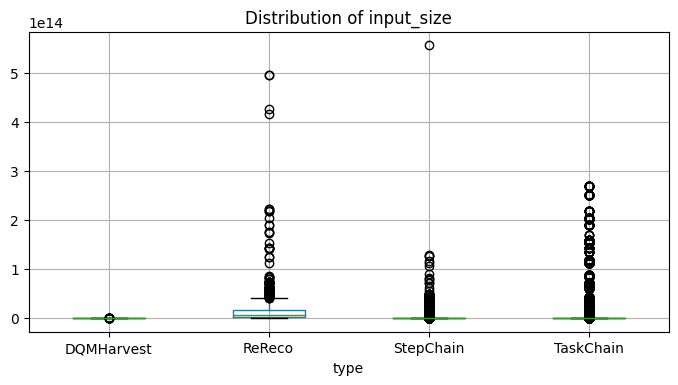

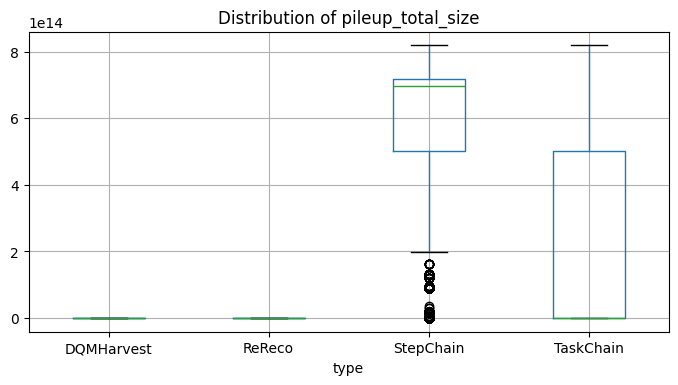

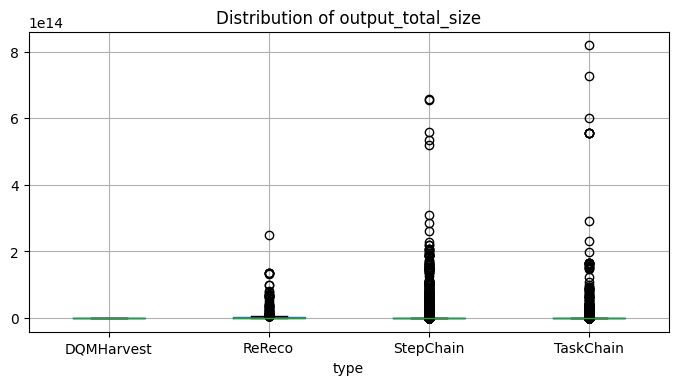

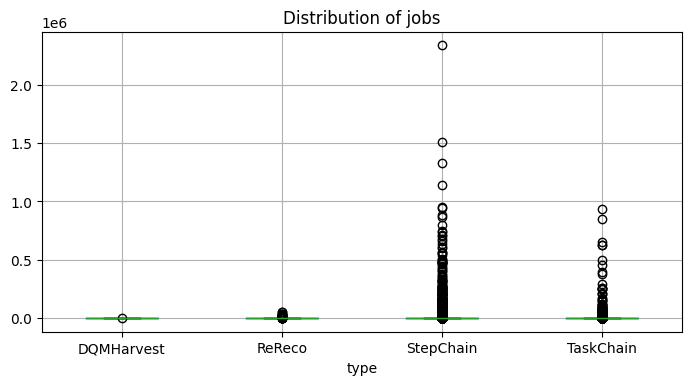

In [621]:
for col in good_cont_features:
    this_title = f"Distribution of {col}"
    df.boxplot(column=col, by='type', figsize=(8, 4))
    plt.title(this_title)
    plt.suptitle('')
    plt.show()

#### Scatter plot of workflow lifetime vs events

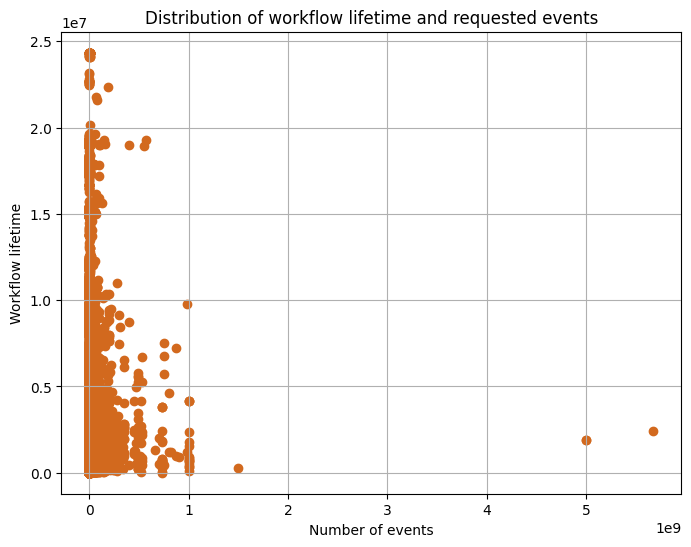

In [622]:
# FIXME: should we remove outliers? how about mean + 3 sigma?

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['events'], df['lifetime'], color='chocolate')

# Customize the plot
plt.xlabel('Number of events')
plt.ylabel('Workflow lifetime')
plt.title('Distribution of workflow lifetime and requested events')
plt.grid(True)
plt.show()

### Step 6c: standardized continuous features and make plots again

In [623]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# create a new panda dataframe and standardize continuous features (x - u / s)
df_scal = df.copy(deep=True)
df_scal[good_cont_features] = scaler.fit_transform(df_scal[good_cont_features])
df_scal.describe()

,events,jobs,lifetime,has_input,input_size,pileup_dset_count,pileup_total_size,output_dset_count,output_total_size,new_ts,assignment-approved_ts,assigned_ts,staging_ts,staged_ts,acquired_ts,running-open_ts,running-closed_ts,completed_ts,closed-out_ts,announced_ts,force-complete_ts,aborted_ts,aborted-completed_ts,rejected_ts,normal-archived_ts,aborted-archived_ts,rejected-archived_ts
count,6.214900e+04,6.213800e+04,6.079900e+04,62153.000000,6.215300e+04,62153.000000,6.215300e+04,62153.000000,6.215300e+04,6.215300e+04,6.215300e+04,6.215300e+04,6.215300e+04,6.215200e+04,6.214900e+04,5.591300e+04,5.545000e+04,5.228300e+04,5.101000e+04,5.076900e+04,3.720000e+02,2.570000e+03,2.569000e+03,1.498000e+03,3.731600e+04,2.553000e+03,1.401000e+03
mean,6.402419e-18,-5.488759e-18,7.479520e-17,0.230592,-2.835174e-17,0.738854,1.975476e-16,4.166396,1.097487e-17,1.704541e+09,1.704545e+09,1.704785e+09,1.704786e+09,1.704806e+09,1.704808e+09,1.705826e+09,1.705931e+09,1.706196e+09,1.706411e+09,1.706439e+09,1.707481e+09,1.702566e+09,1.702567e+09,1.703004e+09,1.702961e+09,1.702649e+09,1.702011e+09
std,1.000008e+00,1.000008e+00,1.000008e+00,0.421215,1.000008e+00,0.439775,1.000008e+00,3.895825,1.000008e+00,8.298557e+06,8.297360e+06,8.587431e+06,8.587403e+06,8.569861e+06,8.569827e+06,9.433842e+06,9.373894e+06,9.411786e+06,9.367302e+06,9.359389e+06,6.228929e+06,4.568870e+06,4.569468e+06,7.948808e+06,7.321787e+06,4.378949e+06,6.753272e+06
min,-8.847358e-02,-8.935793e-02,-8.470063e-01,0.000000,-1.359124e-01,0.000000,-1.381514e+00,0.000000,-1.001966e-01,1.688255e+09,1.688356e+09,1.688359e+09,1.688359e+09,1.688362e+09,1.688363e+09,1.688363e+09,1.688363e+09,1.688390e+09,1.688390e+09,1.688394e+09,1.692275e+09,1.688701e+09,1.688702e+09,1.688701e+09,1.688595e+09,1.688887e+09,1.688887e+09
25%,-8.797874e-02,-8.817644e-02,-7.049825e-01,0.000000,-1.359124e-01,0.000000,-1.381514e+00,3.000000,-9.927809e-02,1.697142e+09,1.697142e+09,1.697210e+09,1.697210e+09,1.697635e+09,1.697642e+09,1.696666e+09,1.697211e+09,1.697256e+09,1.697451e+09,1.697444e+09,1.703595e+09,1.701349e+09,1.701350e+09,1.698248e+09,1.697545e+09,1.701534e+09,1.697911e+09
50%,-8.649420e-02,-8.560248e-02,-3.299262e-01,0.000000,-1.359124e-01,1.000000,4.920231e-01,3.000000,-9.628236e-02,1.703093e+09,1.703093e+09,1.703096e+09,1.703096e+09,1.703099e+09,1.703100e+09,1.704816e+09,1.704863e+09,1.705505e+09,1.705873e+09,1.705875e+09,1.709223e+09,1.701368e+09,1.701369e+09,1.699641e+09,1.702332e+09,1.701565e+09,1.699836e+09
75%,-8.155959e-02,-7.982162e-02,2.209076e-01,0.000000,-1.359124e-01,1.000000,8.655815e-01,3.000000,-8.582613e-02,1.711277e+09,1.711277e+09,1.711279e+09,1.711279e+09,1.711281e+09,1.711282e+09,1.714675e+09,1.714676e+09,1.714755e+09,1.714780e+09,1.714769e+09,1.711825e+09,1.701448e+09,1.701452e+09,1.707731e+09,1.708281e+09,1.701624e+09,1.706327e+09
max,1.122839e+02,9.853605e+01,6.867178e+00,1.000000,3.308994e+01,2.000000,1.177781e+00,19.000000,6.900336e+01,1.719703e+09,1.719913e+09,1.720794e+09,1.720794e+09,1.720795e+09,1.720796e+09,1.720836e+09,1.720836e+09,1.720830e+09,1.720836e+09,1.720833e+09,1.720683e+09,1.720430e+09,1.720430e+09,1.720767e+09,1.719240e+09,1.718996e+09,1.719210e+09


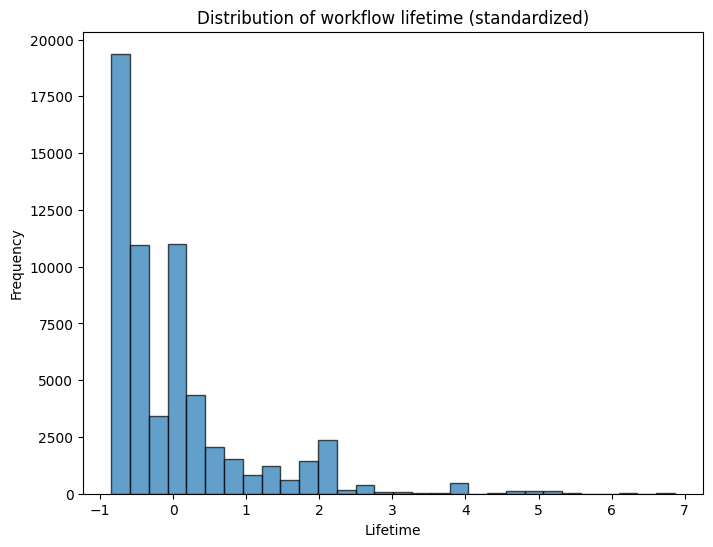

In [624]:
# Plot distribution of the lifetime attribute
plt.figure(figsize=(8, 6))
plt.hist(df_scal['lifetime'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of workflow lifetime (standardized)')
plt.xlabel('Lifetime')
plt.ylabel('Frequency')
plt.show()

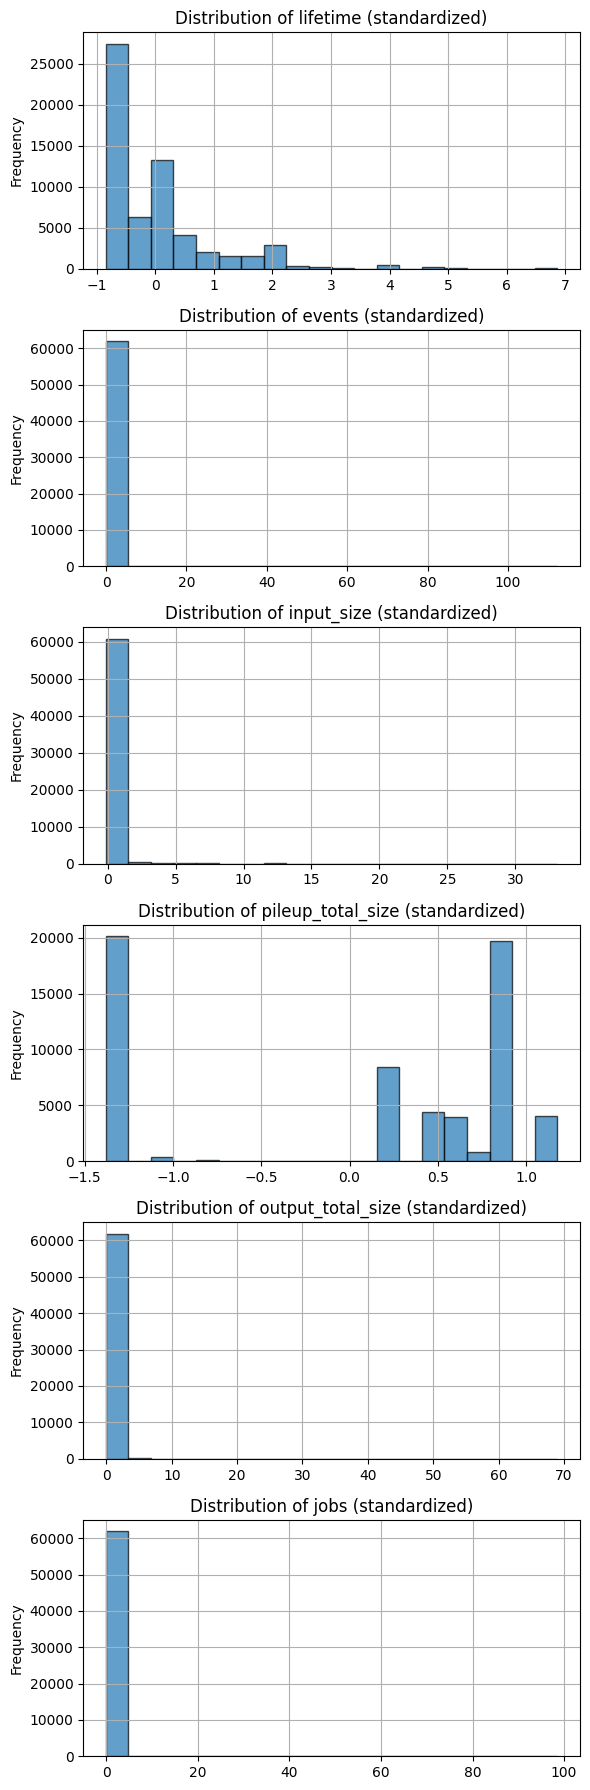

In [625]:
fig, ax = plt.subplots(nrows=len(good_cont_features), figsize=(6,3*len(good_cont_features)))
for i, col in enumerate(good_cont_features):
    plt_title = f"Distribution of {col} (standardized)"
    df_scal[col].plot(kind='hist', ax=ax[i], title=plt_title, bins=20, grid=True, edgecolor='k', alpha=0.7)
    
plt.tight_layout()

#### Make boxplots for continuous features

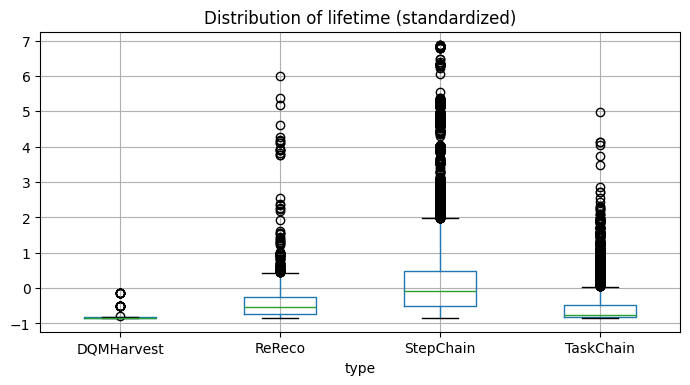

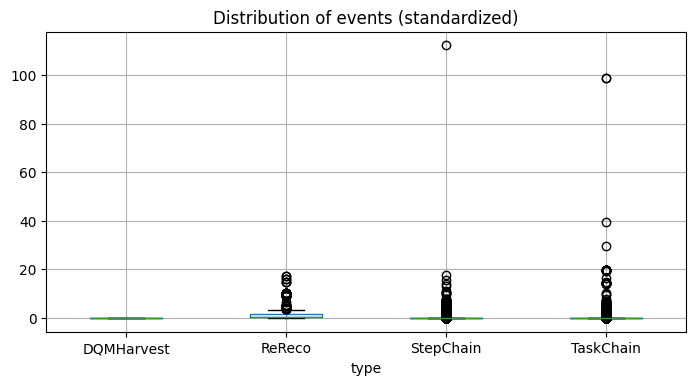

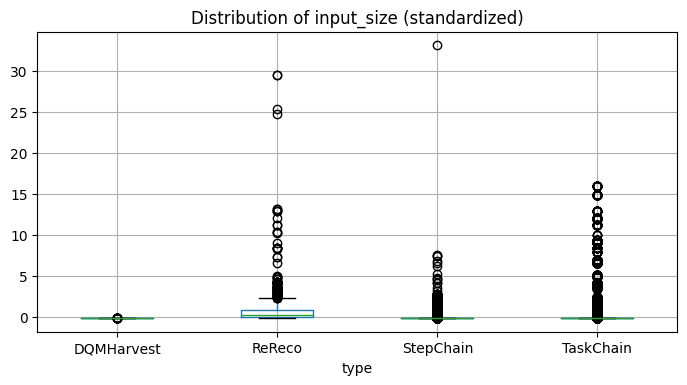

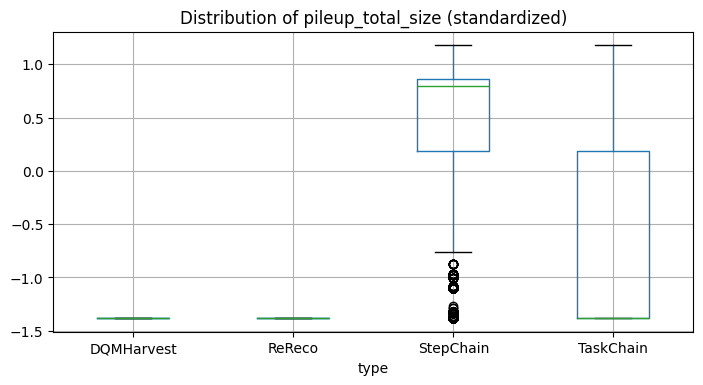

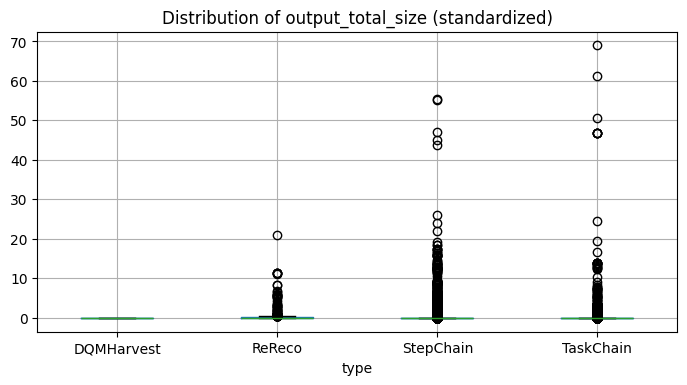

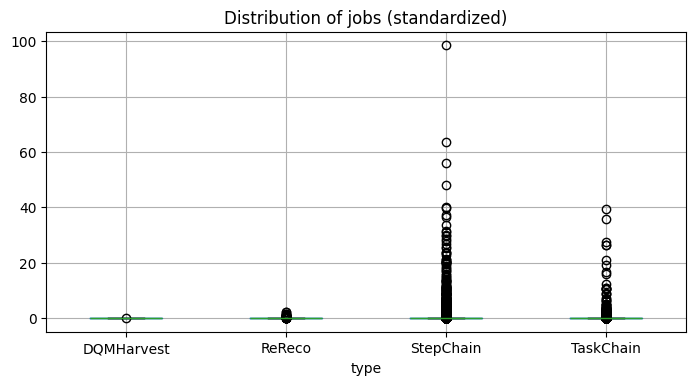

In [626]:
for col in good_cont_features:
    plt_title = f"Distribution of {col} (standardized)"
    df_scal.boxplot(column=col, by='type', figsize=(8, 4))
    plt.title(plt_title)
    plt.suptitle('')
    plt.show()

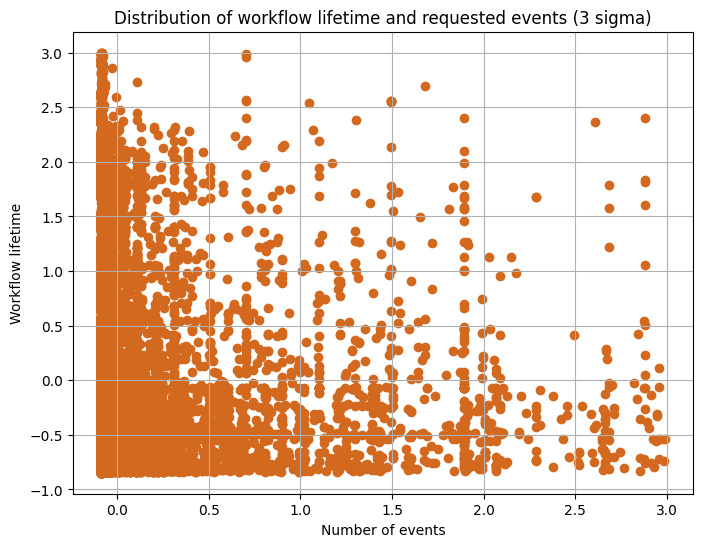

In [627]:
# FIXME: should we remove outliers? how about mean + 2 sigma? Example:
filtered_df = df_scal[df_scal['events'] < 3]
filtered_df = filtered_df[filtered_df['lifetime'] < 3]

# Create the scatter plot
plt.figure(figsize=(8, 6))
#plt.scatter(df['events'], df['lifetime'], color='chocolate')
plt.scatter(filtered_df['events'], filtered_df['lifetime'], color='chocolate')

# Customize the plot
plt.xlabel('Number of events')
plt.ylabel('Workflow lifetime')
plt.title('Distribution of workflow lifetime and requested events (3 sigma)')
plt.grid(True)
plt.show()

### Step 6d: same standardized plots, but with 3 sigma

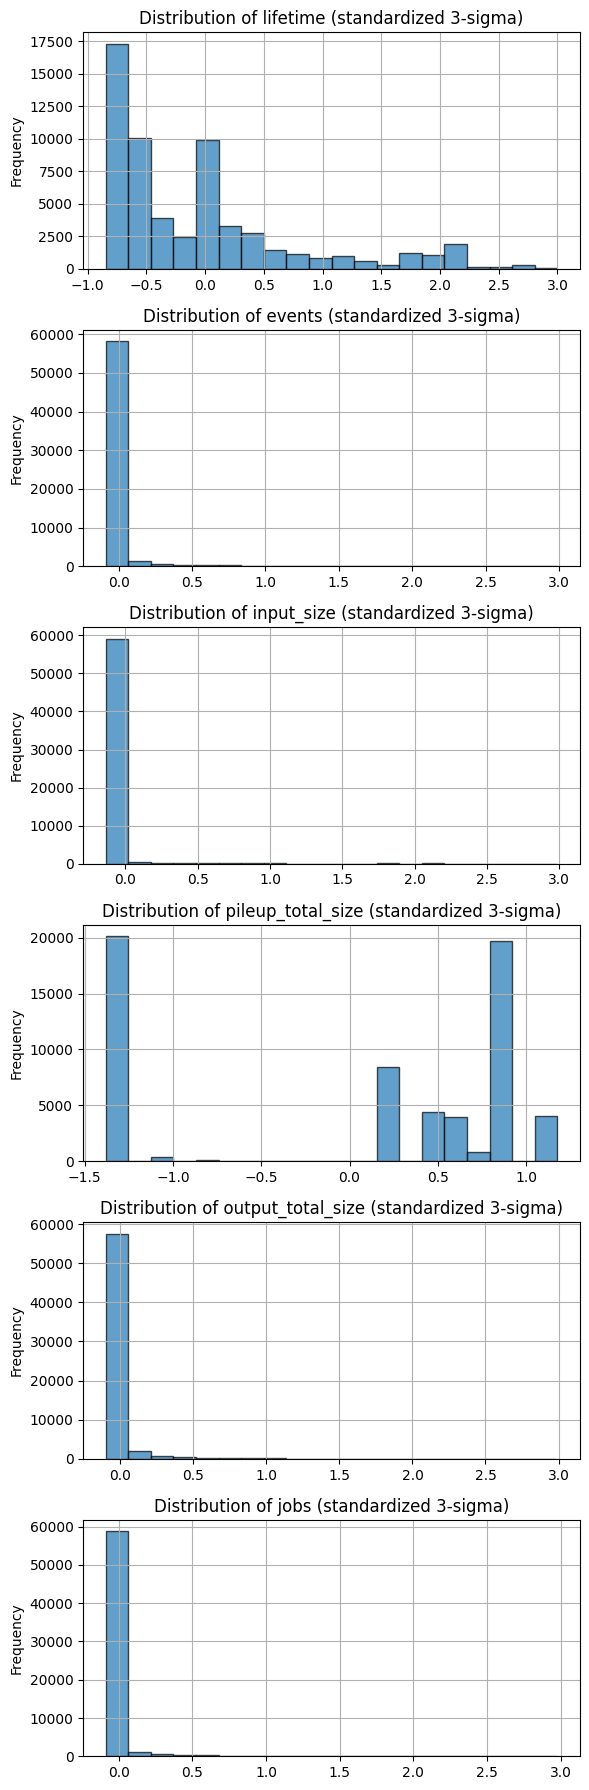

In [628]:
fig, ax = plt.subplots(nrows=len(good_cont_features), figsize=(6,3*len(good_cont_features)))
for i, col in enumerate(good_cont_features):
    filtered_df = df_scal[df_scal[col] < 3]
    plt_title = f"Distribution of {col} (standardized 3-sigma)"
    filtered_df[col].plot(kind='hist', ax=ax[i], title=plt_title, bins=20, grid=True, edgecolor='k', alpha=0.7)
    
plt.tight_layout()

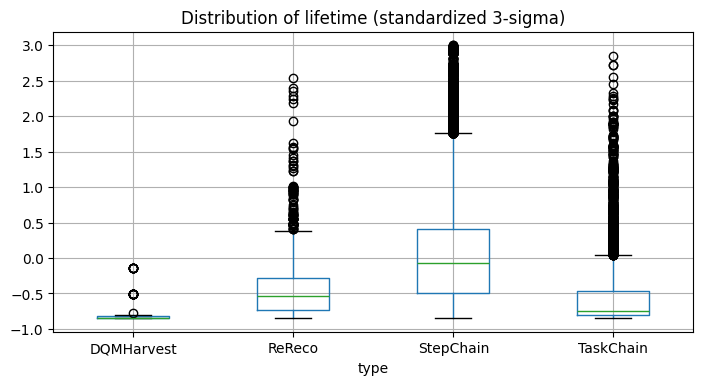

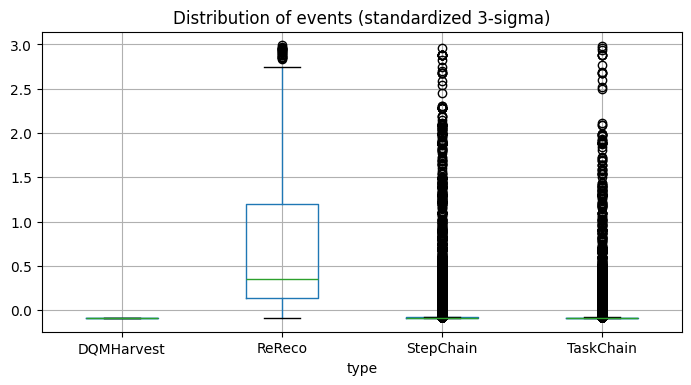

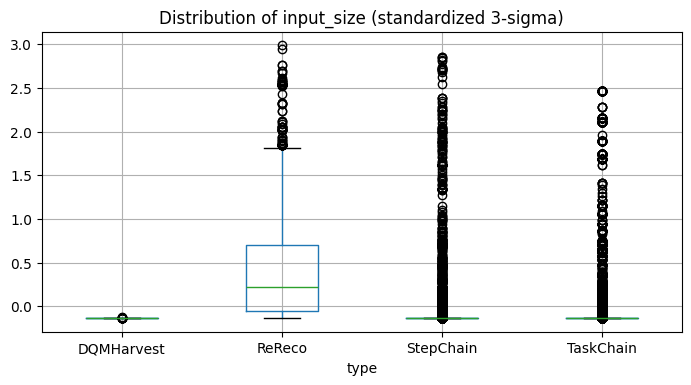

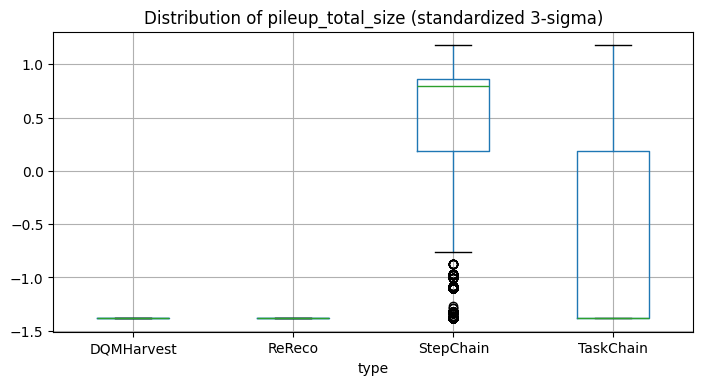

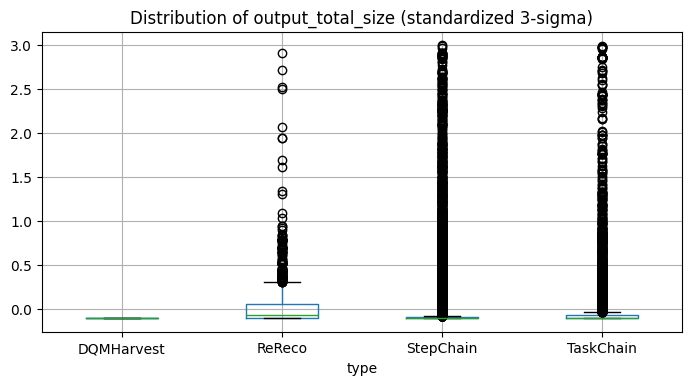

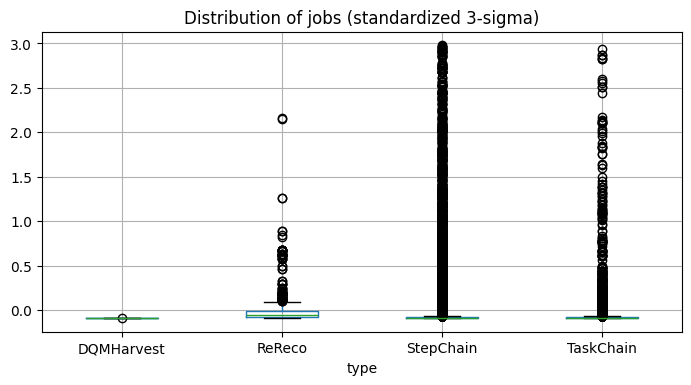

In [629]:
for col in good_cont_features:
    filtered_df = df_scal[df_scal[col] < 3]
    plt_title = f"Distribution of {col} (standardized 3-sigma)"
    filtered_df.boxplot(column=col, by='type', figsize=(8, 4))
    plt.title(plt_title)
    plt.suptitle('')
    plt.show()

## Step 7: Analysis of the data volume in general

In [639]:
### FIXME: first, we need to scale back the data to the original representation - something is not working!
#df[cont_features] = scaler.inverse_transform(df[cont_features])
#print(df[df['input_size'] < 0])

df.agg({"input_size": ["count", "min", "max", "sum", "mean", "std", "median"],
        "pileup_total_size": ["count", "min", "max", "sum", "mean", "std", "median"],
        "output_total_size": ["count", "min", "max", "sum", "mean", "std", "median"]
        })

,input_size,pileup_total_size,output_total_size
count,6.215300e+04,6.215300e+04,6.215300e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
max,5.562782e+14,8.188694e+14,8.188694e+14
sum,1.414286e+17,9.026614e+18,7.379538e+16
mean,2.275491e+12,4.420279e+14,1.187318e+12
std,1.674246e+13,3.199616e+14,1.184998e+13
median,0.000000e+00,5.994551e+14,4.638282e+10


In [684]:
# output data is always unique
total_output_size = df['output_total_size'].sum()
total_input_size = df['input_size'].sum()
print(f"Sum of all input data in one year: {convert_size(total_input_size)}")

# input data can be shared among different workflows, filter for unique datasets
# First, find rows with unique values in the 'input_dset' column, then filter unique values
unique_values_mask = ~df['input_dset'].duplicated(keep=False)
unique_values_df = df[unique_values_mask]
total_input_size = unique_values_df['input_size'].sum()

print(f"Sum of all input data in one year (unique dataset): {convert_size(total_input_size)}")
#print(f"WRONG! Sum of all pileup data in one year: {convert_size(df['pileup_total_size'].sum())}")
print(f"Sum of all output dataset in one year: {convert_size(total_output_size)}")

Sum of all input data in one year: 125.61 PB
Sum of all input data in one year (unique dataset): 18.17 PB
Sum of all output dataset in one year: 65.54 PB


In [641]:
unique_pu_values = df['pileup_total_size'].unique()
print(f"Here is a better calculation of the pileup total volume, based on unique sizes: {convert_size(unique_pu_values.sum())}")

### Cross-checking with the json dump
with open("pileup_dset_size.json") as jobj:
    pu_ddd = json.load(jobj)
print(f"Or using the dump of all pileup dataset sizes: {convert_size(sum(pu_ddd.values()))}")

################################# 

mspileup_url = "https://cmsweb.cern.ch/ms-pileup/data/pileup"
headers = {"Content-type": "application/json", "Accept": "application/json"}
queryParams = {}
mspu_data = requests.get(mspileup_url, params=queryParams, headers=headers, cert=(myCert, myKey), verify=False)
if mspu_data.ok is True:
    mspu_data = mspu_data.json()['result']
single_rse_pu = sum([doc['pileupSize'] for doc in mspu_data])
multi_rse_pu = sum([doc['pileupSize'] * len(doc['expectedRSEs']) for doc in mspu_data])
print(f"Number of active/disabled pileups: {len(mspu_data)}")
print(f"  * single replica volume: {convert_size(single_rse_pu)}\n  * multi replica volume: {convert_size(multi_rse_pu)}")

total_pileup_size = multi_rse_pu

Here is a better calculation of the pileup total volume, based on unique sizes: 7.25 PB
Or using the dump of all pileup dataset sizes: 6.74 PB
Number of active/disabled pileups: 177
  * single replica volume: 7.09 PB
  * multi replica volume: 12.37 PB


/Users/amaltar2/.virtualenvs/cse-neural/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [642]:
column_names = ["Data type", "Total data volume", "Comments"]
total = total_input_size + total_pileup_size + total_output_size
table_data = [["Input", convert_size(total_input_size), "Considering unique input dataset"],
              ["Pileup", convert_size(total_pileup_size), "Considering unique and mutiple replicas/RSE"],
              ["Output", convert_size(total_output_size), "This does not consider wma_prod rules (x2)"],
              ["TOTAL", convert_size(total), ""]]

print("Summary of all the data volume required in 1 year (July/2023 - June/2024)")
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

Summary of all the data volume required in 1 year (July/2023 - June/2024)
╒═════════════╤═════════════════════╤═════════════════════════════════════════════╕
│ Data type   │ Total data volume   │ Comments                                    │
╞═════════════╪═════════════════════╪═════════════════════════════════════════════╡
│ Input       │ 18.17 PB            │ Considering unique input dataset            │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ Pileup      │ 12.37 PB            │ Considering unique and mutiple replicas/RSE │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ Output      │ 65.54 PB            │ This does not consider wma_prod rules (x2)  │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ TOTAL       │ 96.08 PB            │                                             │
╘═════════════╧═════════════════════╧═════════════════════════════════════════════╛


### Step 7a: Analysis of data volume for 2023

In [685]:
epoch_2023 = 1704067201  # for Monday, January 1, 2024 12:00:01 AM
df_2023 = df[(df['normal-archived_ts'] < epoch_2023) |
             (df['aborted-archived_ts'] < epoch_2023) |
             (df['rejected-archived_ts'] < epoch_2023)]
print(f"Total workflows archived in 2023: {len(df_2023)}")

# output data is always unique
total_output_size_2023 = df_2023['output_total_size'].sum()
total_input_size_2023 = df_2023['input_size'].sum()
print(f"Sum of all input data in one year: {convert_size(total_input_size_2023)}")

# input data can be shared among different workflows, filter for unique datasets
# First, find rows with unique values in the 'input_dset' column, then filter unique values
unique_values_mask_2023 = ~df_2023['input_dset'].duplicated(keep=False)
unique_values_df_2023 = df_2023[unique_values_mask_2023]
total_input_size_2023 = unique_values_df_2023['input_size'].sum()

print(f"Sum of all input data in one year (unique datasets): {convert_size(total_input_size_2023)}")
#print(f"WRONG! Sum of all pileup data in one year: {convert_size(df['pileup_total_size'].sum())}")
print(f"Sum of all output dataset in one year: {convert_size(total_output_size_2023)}")


column_names = ["Data type", "Total data volume", "Comments"]
total = total_input_size_2023 + total_pileup_size + total_output_size_2023
table_data = [["Input", convert_size(total_input_size_2023), "Considering unique input dataset"],
              ["Pileup", convert_size(total_pileup_size), "Considering unique and mutiple replicas/RSE"],
              ["Output", convert_size(total_output_size_2023), "This does not consider wma_prod rules (x2)"],
              ["TOTAL", convert_size(total), ""]]

print("\nSummary of all the data volume required for the 2nd semester in 2023")
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

Total workflows archived in 2023: 22587
Sum of all input data in one year: 64.1 PB
Sum of all input data in one year (unique datasets): 14.76 PB
Sum of all output dataset in one year: 22.32 PB

Summary of all the data volume required for the 2nd semester in 2023
╒═════════════╤═════════════════════╤═════════════════════════════════════════════╕
│ Data type   │ Total data volume   │ Comments                                    │
╞═════════════╪═════════════════════╪═════════════════════════════════════════════╡
│ Input       │ 14.76 PB            │ Considering unique input dataset            │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ Pileup      │ 12.37 PB            │ Considering unique and mutiple replicas/RSE │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ Output      │ 22.32 PB            │ This does not consider wma_prod rules (x2)  │
├─────────────┼─────────────────────┼────────────────────────────

### Step 7b: Analysis of data volume for 2024

In [687]:
df_2024 = df[(df['normal-archived_ts'] >= epoch_2023) |
             (df['aborted-archived_ts'] >= epoch_2023) |
             (df['rejected-archived_ts'] >= epoch_2023)]
print(f"Total workflows archived in 2024: {len(df_2024)}")

# output data is always unique
total_output_size_2024 = df_2024['output_total_size'].sum()
total_input_size_2024 = df_2024['input_size'].sum()
print(f"Sum of all input data in one year: {convert_size(total_input_size_2024)}")

# input data can be shared among different workflows, filter for unique datasets
# First, find rows with unique values in the 'input_dset' column, then filter unique values
unique_values_mask_2024 = ~df_2024['input_dset'].duplicated(keep=False)
unique_values_df_2024 = df_2024[unique_values_mask_2024]
total_input_size_2024 = unique_values_df_2024['input_size'].sum()

print(f"Sum of all input data in one year (unique dataset): {convert_size(total_input_size_2024)}")
#print(f"WRONG! Sum of all pileup data in one year: {convert_size(df['pileup_total_size'].sum())}")
print(f"Sum of all output dataset in one year: {convert_size(total_output_size_2024)}")


column_names = ["Data type", "Total data volume", "Comments"]
total = total_input_size_2024 + total_pileup_size + total_output_size_2024
table_data = [["Input", convert_size(total_input_size_2024), "Considering unique input dataset"],
              ["Pileup", convert_size(total_pileup_size), "Considering unique and mutiple replicas/RSE"],
              ["Output", convert_size(total_output_size_2024), "This does not consider wma_prod rules (x2)"],
              ["TOTAL", convert_size(total), ""]]

print("\nSummary of all the data volume required for the 1st semester in 2024")
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

Total workflows archived in 2024: 18683
Sum of all input data in one year: 55.13 PB
Sum of all input data in one year (unique dataset): 3.53 PB
Sum of all output dataset in one year: 20.1 PB

Summary of all the data volume required for the 1st semester in 2024
╒═════════════╤═════════════════════╤═════════════════════════════════════════════╕
│ Data type   │ Total data volume   │ Comments                                    │
╞═════════════╪═════════════════════╪═════════════════════════════════════════════╡
│ Input       │ 3.53 PB             │ Considering unique input dataset            │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ Pileup      │ 12.37 PB            │ Considering unique and mutiple replicas/RSE │
├─────────────┼─────────────────────┼─────────────────────────────────────────────┤
│ Output      │ 20.1 PB             │ This does not consider wma_prod rules (x2)  │
├─────────────┼─────────────────────┼──────────────────────────────

### Step 7c: analysis based on the "announced" status instead of archived

In [772]:
######## 2023
df_2023 = df[(df['announced_ts'] < epoch_2023)]

# output data is always unique
total_output_size_2023 = df_2023['output_total_size'].sum()
total_input_size_2023 = df_2023['input_size'].sum()

unique_values_mask_2023 = ~df_2023['input_dset'].duplicated(keep=False)
unique_values_df_2023 = df_2023[unique_values_mask_2023]
total_input_size_2023 = unique_values_df_2023['input_size'].sum()

######## 2024
df_2024 = df[(df['announced_ts'] >= epoch_2023)]

# output data is always unique
total_output_size_2024 = df_2024['output_total_size'].sum()
total_input_size_2024 = df_2024['input_size'].sum()
print(f"Sum of non-unique input data for 2/2023: {convert_size(total_input_size_2023)}, for 1/2024: {convert_size(total_input_size_2024)}")

unique_values_mask_2024 = ~df_2024['input_dset'].duplicated(keep=False)
unique_values_df_2024 = df_2024[unique_values_mask_2024]
total_input_size_2024 = unique_values_df_2024['input_size'].sum()

######## Create table

column_names = ["Data type", "Total data volume 2/2023", "Total data volume 1/2024", "Comments"]
total_2023 = total_input_size_2023 + total_pileup_size + total_output_size_2023
total_2023_2x = total_input_size_2023 + total_pileup_size + total_output_size_2023 + total_output_size_2023
total_2024 = total_input_size_2024 + total_pileup_size + total_output_size_2024
total_2024_2x = total_input_size_2024 + total_pileup_size + total_output_size_2024 + total_output_size_2024
table_data = [["Workflow Count", len(df_2023), len(df_2024), ""],
              ["Input", convert_size(total_input_size_2023), convert_size(total_input_size_2024), "Considering unique input dataset"],
              ["Pileup", convert_size(total_pileup_size), convert_size(total_pileup_size), "Considering unique and mutiple replicas/RSE"],
              ["Output", convert_size(total_output_size_2023), convert_size(total_output_size_2024), "This does not consider wma_prod rules (x2)"],
              ["TOTAL", convert_size(total_2023), convert_size(total_2024), "Considering single replica for output data"],
              ["TOTAL 2x", convert_size(total_2023_2x), convert_size(total_2024_2x), "Considering multiple replicas for output data"]]

print("\nSummary of all the data volume required for the 2/2023 and 1/2024 (based on announced status)")
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

Sum of non-unique input data for 2/2023: 15.56 PB, for 1/2024: 53.38 PB

Summary of all the data volume required for the 2/2023 and 1/2024 (based on announced status)
╒════════════════╤════════════════════════════╤════════════════════════════╤═══════════════════════════════════════════════╕
│ Data type      │ Total data volume 2/2023   │ Total data volume 1/2024   │ Comments                                      │
╞════════════════╪════════════════════════════╪════════════════════════════╪═══════════════════════════════════════════════╡
│ Workflow Count │ 20405                      │ 30364                      │                                               │
├────────────────┼────────────────────────────┼────────────────────────────┼───────────────────────────────────────────────┤
│ Input          │ 15.56 PB                   │ 4.08 PB                    │ Considering unique input dataset              │
├────────────────┼────────────────────────────┼────────────────────────────┼───────

## Step 8: event throughput analysis

In [666]:
df.agg({"events": ["count", "min", "max", "sum", "mean",  "std", "median"],
        "jobs": ["count", "min", "max", "sum", "mean", "std", "median"],
        "lifetime": ["count", "min", "max", "sum", "mean", "std", "median"]
        })
len(df[df['events'] == 0])

179

In [663]:
print(f"Daily event throughput: {(df['events'].sum() / 365)/1024**2:1f} million events")
print(f"Daily job throughput: {df['jobs'].sum() / 365:2f}")

Daily event throughput: 725.813390 million events
Daily job throughput: 360687.101370


In [699]:
df_2023 = df[(df['closed-out_ts'] < epoch_2023)]
print(f"Total workflows closed-out in 2023: {len(df_2023)}")
evt_through_2023 = (df_2023['events'].sum() / (6 * 30)) # / 1024**2
job_through_2023 = df_2023['jobs'].sum() / (6 * 30)
out_size_daily_2023 = total_output_size_2023 / (6 * 30)

df_2024 = df[(df['closed-out_ts'] >= epoch_2023)]
print(f"Total workflows closed-out in 2024: {len(df_2024)}")
evt_through_2024 = (df_2024['events'].sum() / (6 * 30)) # / 1024**2
job_through_2024 = df_2024['jobs'].sum() / (6 * 30)
out_size_daily_2024 = total_output_size_2024 / (6 * 30)

column_names = ["Metric", "2/2023", "1/2024"]
table_data = [["Daily event throughput", f"{evt_through_2023:.2E}", f"{evt_through_2024:.2E}"],
              ["Daily job througput", f"{job_through_2023:.2E}", f"{job_through_2024:.2E}"],
              ["Daily output data volume", convert_size(out_size_daily_2023), convert_size(out_size_daily_2024)]]

print("\nSummary of event and job throughput in the past 2 semesters")
print(tabulate(table_data, headers=column_names, tablefmt="fancy_grid"))

Total workflows closed-out in 2023: 20473
Total workflows closed-out in 2024: 30537

Summary of event and job throughput in the past 2 semesters
╒══════════════════════════╤═══════════╤═══════════╕
│ Metric                   │ 2/2023    │ 1/2024    │
╞══════════════════════════╪═══════════╪═══════════╡
│ Daily event throughput   │ 6.66E+08  │ 5.34E+08  │
├──────────────────────────┼───────────┼───────────┤
│ Daily job througput      │ 2.10E+05  │ 3.35E+05  │
├──────────────────────────┼───────────┼───────────┤
│ Daily output data volume │ 126.97 TB │ 114.37 TB │
╘══════════════════════════╧═══════════╧═══════════╛


## Step 9: Clustering interesting continuous features (K-Means)

In [710]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [718]:
X_scal = df_scal[good_cont_features]
X_scal.describe()
# remove nans
X_scal = X_scal.dropna()
X_scal.describe()

,lifetime,events,input_size,pileup_total_size,output_total_size,jobs
count,60794.000000,60794.000000,60794.000000,60794.000000,60794.000000,60794.000000
mean,0.000062,-0.001710,0.001853,-0.015717,-0.005142,-0.005771
std,1.000025,0.984551,1.002445,1.002916,0.899036,0.940969
min,-0.847006,-0.088474,-0.135912,-1.381514,-0.100197,-0.089358
25%,-0.704954,-0.087979,-0.135912,-1.381514,-0.099312,-0.088219
50%,-0.329753,-0.086494,-0.135912,0.492023,-0.096263,-0.085602
75%,0.220966,-0.081558,-0.135912,0.865582,-0.085662,-0.079864
max,6.867178,112.283875,33.089945,1.177781,69.003357,98.536047


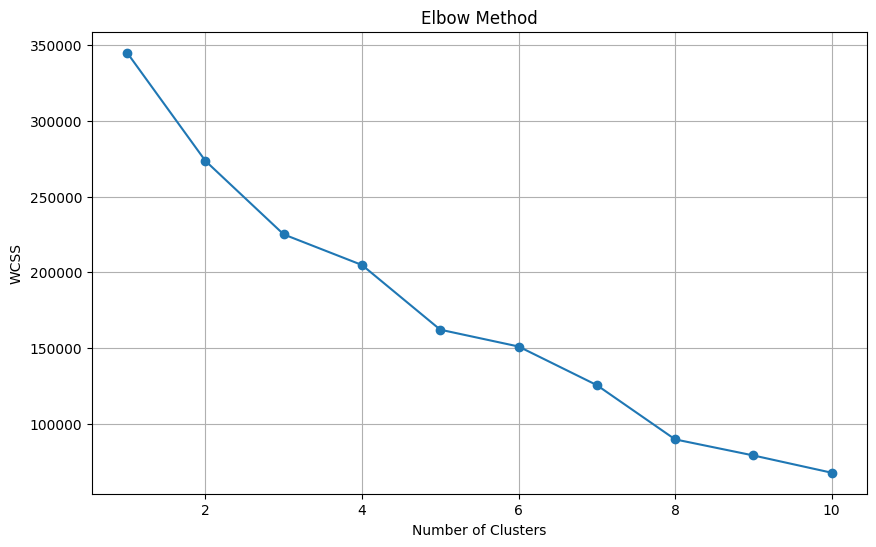

In [719]:
# Elbow method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scal)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

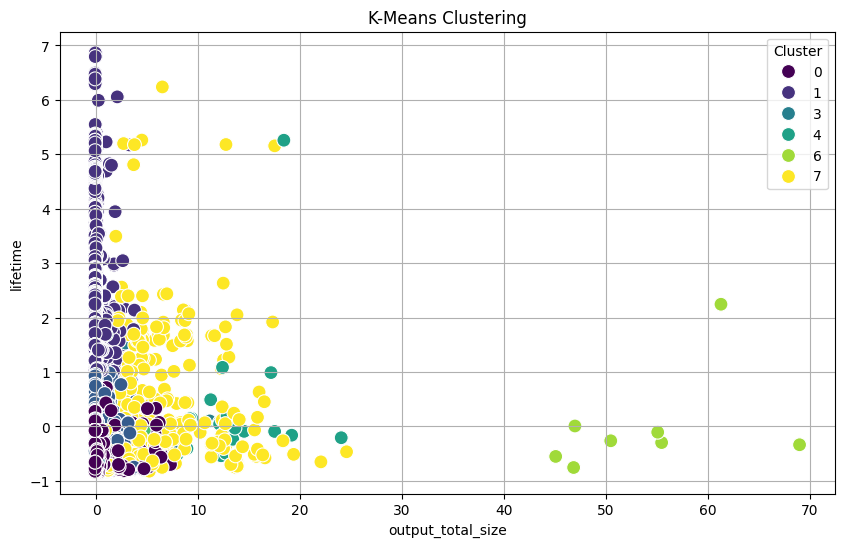

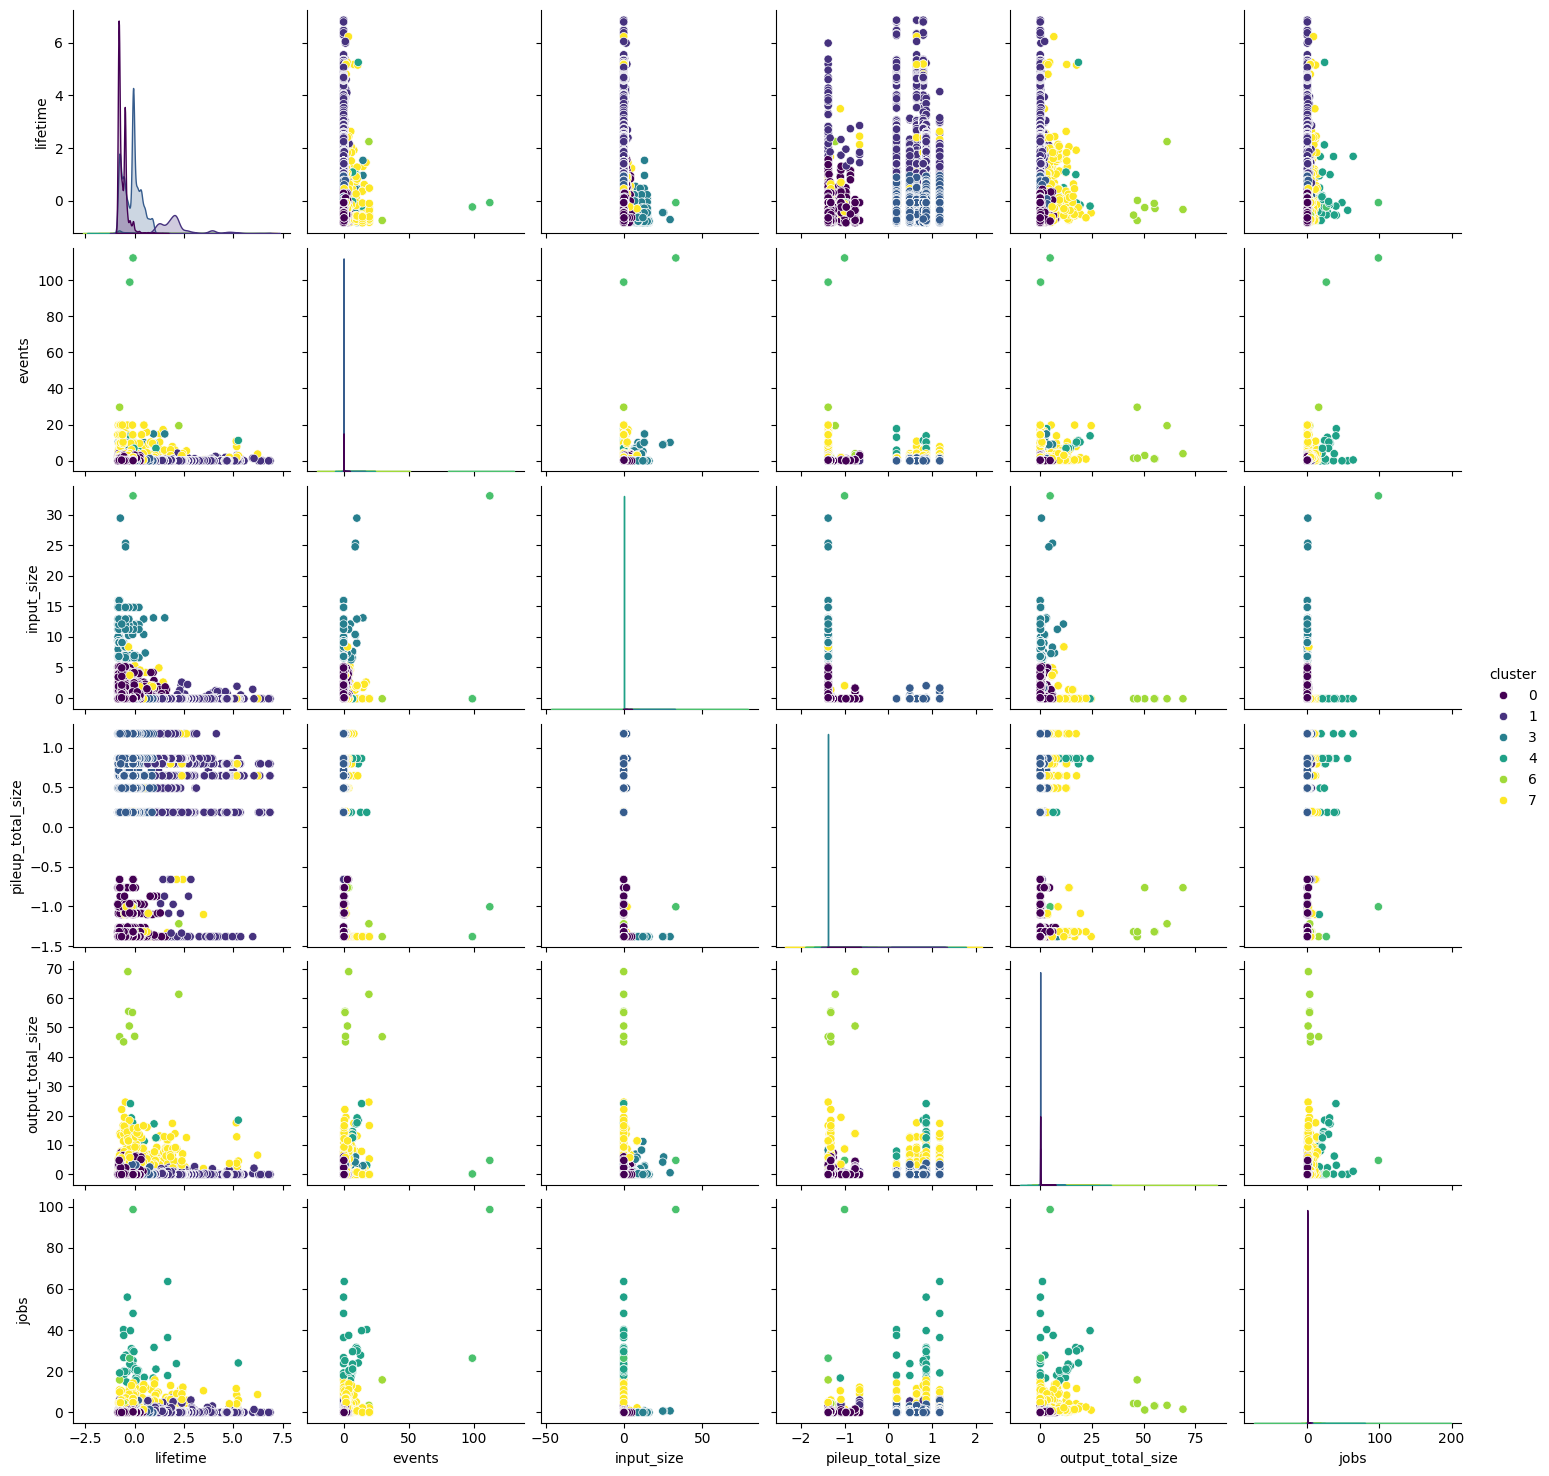

In [722]:
# Optimal number of clusters (e.g., 8)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_scal['cluster'] = kmeans.fit_predict(X_scal)

# Scatter plot for 2D data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='output_total_size', y='lifetime', hue='cluster', data=X_scal, palette='viridis', s=100)
plt.title('K-Means Clustering')
plt.xlabel('output_total_size')
plt.ylabel('lifetime')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Pair plot for multidimensional data
sns.pairplot(X_scal, hue='cluster', palette='viridis')  # , markers=["o", "s", "D"])
plt.show()


## Step 10: Time series analysis

In [749]:
import datetime as dt

# Generate date range daily
date_range = pd.date_range(start='2023-07-01', end='2024-07-01', freq='D')
epoch_time = date_range.astype(int) // 10**9
zero_data = np.zeros(len(date_range))
# Convert to a DataFrame for better readability
date_df = pd.DataFrame({'date': date_range, 'epoch_time': epoch_time, 'output_size': zero_data})
date_df.head()

,date,epoch_time,output_size
0,2023-07-01,1688169600,0.0
1,2023-07-02,1688256000,0.0
2,2023-07-03,1688342400,0.0
3,2023-07-04,1688428800,0.0
4,2023-07-05,1688515200,0.0


In [747]:
df.describe()

,events,jobs,lifetime,has_input,input_size,pileup_dset_count,pileup_total_size,output_dset_count,output_total_size,new_ts,assignment-approved_ts,assigned_ts,staging_ts,staged_ts,acquired_ts,running-open_ts,running-closed_ts,completed_ts,closed-out_ts,announced_ts,force-complete_ts,aborted_ts,aborted-completed_ts,rejected_ts,normal-archived_ts,aborted-archived_ts,rejected-archived_ts,timestamp
count,6.214900e+04,6.213800e+04,6.079900e+04,62153.000000,6.215300e+04,62153.000000,6.215300e+04,62153.000000,6.215300e+04,6.215300e+04,6.215300e+04,6.215300e+04,6.215300e+04,6.215200e+04,6.214900e+04,5.591300e+04,5.545000e+04,5.228300e+04,5.101000e+04,5.076900e+04,3.720000e+02,2.570000e+03,2.569000e+03,1.498000e+03,3.731600e+04,2.553000e+03,1.401000e+03,55913
mean,4.469754e+06,2.118684e+03,2.675700e+06,0.230592,2.275491e+12,0.738854,4.420279e+14,4.166396,1.187318e+12,1.704541e+09,1.704545e+09,1.704785e+09,1.704786e+09,1.704806e+09,1.704808e+09,1.705826e+09,1.705931e+09,1.706196e+09,1.706411e+09,1.706439e+09,1.707481e+09,1.702566e+09,1.702567e+09,1.703004e+09,1.702961e+09,1.702649e+09,1.702011e+09,2024-01-21 08:30:43.737055744
min,0.000000e+00,1.000000e+00,3.477000e+03,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.688255e+09,1.688356e+09,1.688359e+09,1.688359e+09,1.688362e+09,1.688363e+09,1.688363e+09,1.688363e+09,1.688390e+09,1.688390e+09,1.688394e+09,1.692275e+09,1.688701e+09,1.688702e+09,1.688701e+09,1.688595e+09,1.688887e+09,1.688887e+09,2023-07-03 05:36:20
25%,2.500000e+04,2.900000e+01,4.515485e+05,0.000000,0.000000e+00,0.000000,0.000000e+00,3.000000,1.088368e+10,1.697142e+09,1.697142e+09,1.697210e+09,1.697210e+09,1.697635e+09,1.697642e+09,1.696666e+09,1.697211e+09,1.697256e+09,1.697451e+09,1.697444e+09,1.703595e+09,1.701349e+09,1.701350e+09,1.698248e+09,1.697545e+09,1.701534e+09,1.697911e+09,2023-10-07 08:08:24
50%,1.000000e+05,9.000000e+01,1.634815e+06,0.000000,0.000000e+00,1.000000,5.994551e+14,3.000000,4.638282e+10,1.703093e+09,1.703093e+09,1.703096e+09,1.703096e+09,1.703099e+09,1.703100e+09,1.704816e+09,1.704863e+09,1.705505e+09,1.705873e+09,1.705875e+09,1.709223e+09,1.701368e+09,1.701369e+09,1.699641e+09,1.702332e+09,1.701565e+09,1.699836e+09,2024-01-09 16:05:04
75%,3.493000e+05,2.270000e+02,3.372642e+06,0.000000,0.000000e+00,1.000000,7.189785e+14,3.000000,1.702880e+11,1.711277e+09,1.711277e+09,1.711279e+09,1.711279e+09,1.711281e+09,1.711282e+09,1.714675e+09,1.714676e+09,1.714755e+09,1.714780e+09,1.714769e+09,1.711825e+09,1.701448e+09,1.701452e+09,1.707731e+09,1.708281e+09,1.701624e+09,1.706327e+09,2024-05-02 18:35:10
max,5.677138e+09,2.337314e+06,2.434098e+07,1.000000,5.562782e+14,2.000000,8.188694e+14,19.000000,8.188694e+14,1.719703e+09,1.719913e+09,1.720794e+09,1.720794e+09,1.720795e+09,1.720796e+09,1.720836e+09,1.720836e+09,1.720830e+09,1.720836e+09,1.720833e+09,1.720683e+09,1.720430e+09,1.720430e+09,1.720767e+09,1.719240e+09,1.718996e+09,1.719210e+09,2024-07-13 02:03:17
std,5.052118e+07,2.369908e+04,3.154930e+06,0.421215,1.674246e+13,0.439775,3.199616e+14,3.895825,1.184998e+13,8.298557e+06,8.297360e+06,8.587431e+06,8.587403e+06,8.569861e+06,8.569827e+06,9.433842e+06,9.373894e+06,9.411786e+06,9.367302e+06,9.359389e+06,6.228929e+06,4.568870e+06,4.569468e+06,7.948808e+06,7.321787e+06,4.378949e+06,6.753272e+06,NaN


In [773]:
### Now account output_total_size of each data instance to each date in the time series
df.columns
daily_sizes = []
for day_epoch in date_df['epoch_time']:
    # did it start running before this date?
    matched_data = df[df['running-open_ts'] < day_epoch]
    # was it archived before this date
    matched_data = matched_data[(matched_data['normal-archived_ts'] < day_epoch) |
                                (matched_data['aborted-archived_ts'] < day_epoch) |
                                (matched_data['rejected-archived_ts'] < day_epoch)]
    daily_size = convert_to_PB(matched_data['output_total_size'].sum() * 2)  # note the times 2
    print(f"Epoch: {day_epoch} has a total size of {daily_size}")
    daily_sizes.append(daily_size)
date_df['output_size'] = daily_sizes
#        if item['running']
    # consider: running-open_ts, running-closed_ts, completed_ts, closed-out_ts, announced_ts, force-complete_ts, aborted_ts	

Epoch: 1688169600 has a total size of 0.0
Epoch: 1688256000 has a total size of 0.0
Epoch: 1688342400 has a total size of 0.0
Epoch: 1688428800 has a total size of 0.0
Epoch: 1688515200 has a total size of 0.0
Epoch: 1688601600 has a total size of 0.01
Epoch: 1688688000 has a total size of 0.01
Epoch: 1688774400 has a total size of 0.01
Epoch: 1688860800 has a total size of 0.01
Epoch: 1688947200 has a total size of 0.12
Epoch: 1689033600 has a total size of 0.12
Epoch: 1689120000 has a total size of 0.12
Epoch: 1689206400 has a total size of 0.13
Epoch: 1689292800 has a total size of 0.13
Epoch: 1689379200 has a total size of 0.13
Epoch: 1689465600 has a total size of 0.15
Epoch: 1689552000 has a total size of 0.2
Epoch: 1689638400 has a total size of 0.2
Epoch: 1689724800 has a total size of 0.21
Epoch: 1689811200 has a total size of 0.22
Epoch: 1689897600 has a total size of 0.22
Epoch: 1689984000 has a total size of 0.24
Epoch: 1690070400 has a total size of 0.25
Epoch: 1690156800 

In [774]:
date_df.describe()

,date,epoch_time,output_size
count,367,3.670000e+02,367.000000
mean,2023-12-31 00:00:00,1.703981e+09,44.145858
min,2023-07-01 00:00:00,1.688170e+09,0.000000
25%,2023-09-30 12:00:00,1.696075e+09,13.835000
50%,2023-12-31 00:00:00,1.703981e+09,44.640000
75%,2024-03-31 12:00:00,1.711886e+09,76.055000
max,2024-07-01 00:00:00,1.719792e+09,84.850000
std,NaN,9.166004e+06,30.769296


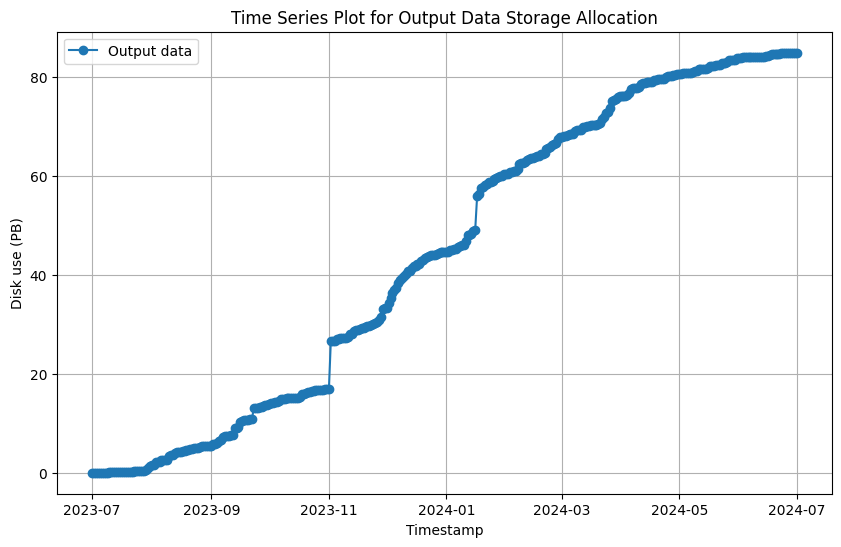

In [775]:
plt.figure(figsize=(10, 6))

# Iterate over each state and plot its time series
#for state in df['state'].unique():
#    state_data = df[df['state'] == state]

plt.plot(date_df['date'], date_df['output_size'], marker='o', linestyle='-', label=f'Output data')

plt.title('Time Series Plot for Output Data Storage Allocation')
plt.xlabel('Timestamp')
plt.ylabel('Disk use (PB)')
plt.legend()
plt.grid(True)
plt.show()

# ===== Auxiliary code ======

## Plotting disk capacity estimates

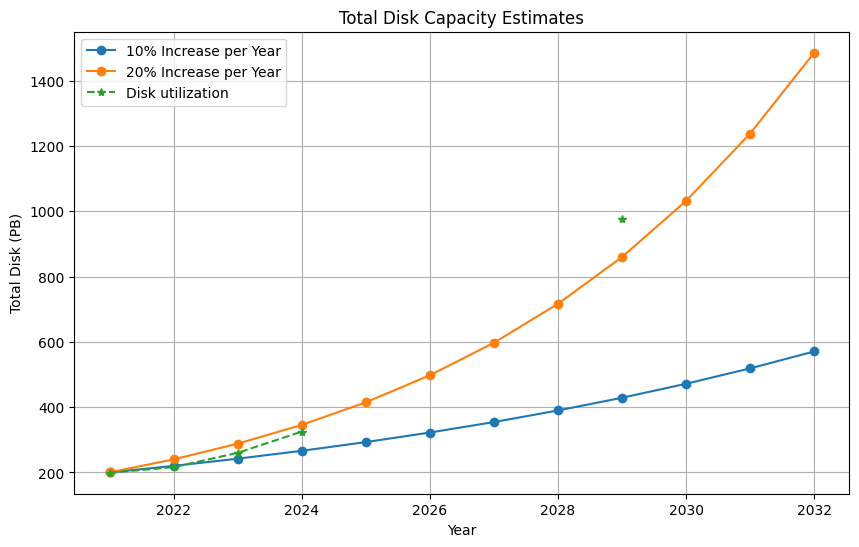

In [776]:
import numpy as np
import matplotlib.pyplot as plt

# Given baseline
P = 200  # PB

# Number of years
n_years = 11

# Annual increase rates
rates = [10, 20]

# Years
years = np.arange(0, n_years + 1)
years_plot = np.arange(2021, 2021 + n_years + 1)

# Calculate future values
#disk_usage = [200, 216, 260, 304, 342, 373, 403, 448, 487, 697, 880, 1031]
disk_usage = [199, 216, 260, 325, None, None, None, None, 3 * 325, None, None, None]  # CMS Required
future_values_10 = P * (1 + 0.10) ** years
future_values_20 = P * (1 + 0.20) ** years

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(years_plot, future_values_10, marker='o', label='10% Increase per Year')
plt.plot(years_plot, future_values_20, marker='o', label='20% Increase per Year')
plt.plot(years_plot, disk_usage, marker='*', linestyle='dashed', label='Disk utilization')
#plt.plot(years_plot, disk_usage, marker='*', linestyle='dashed', label='Disk utilization')
plt.title('Total Disk Capacity Estimates')
plt.xlabel('Year')
plt.ylabel('Total Disk (PB)')
plt.legend()
plt.grid(True)
plt.show()

## Plotting workflow status and data placement relationship

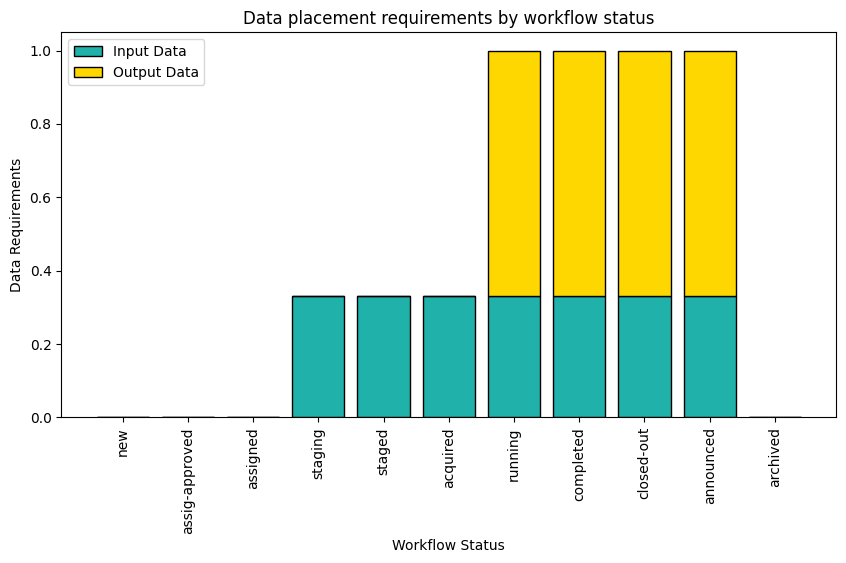

In [50]:
import numpy as np
import matplotlib.pyplot as plt

status = ["new", "assig-approved", "assigned", "staging", "staged",
          "acquired", "running", "completed", "closed-out", "announced", "archived"]

# Input data has 1 replica, while output has 2, hence the different ratio
input_d =  [0, 0, 0, .33, .33, .33, .33, .33, .33, .33, 0]
output_d = [0, 0, 0, 0, 0, 0, .67, .67, .67, .67, 0]

# Calculate the positions for the statuses on the x-axis
x = np.arange(len(status))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each stack component
bar1 = ax.bar(x, input_d, color='lightseagreen', edgecolor='black', label='Input Data')
bar2 = ax.bar(x, output_d, bottom=input_d, color='gold', edgecolor='black', label='Output Data')

# Customize the plot
ax.set_xlabel('Workflow Status')
ax.set_ylabel('Data Requirements')
ax.set_title('Data placement requirements by workflow status')
ax.set_xticks(x)
ax.set_xticklabels(status, rotation=90)
ax.legend()

# Show the plot
plt.show()